# **SCOPE AND BUSINESS ASSUMPTIONS**

- **...**

- **...**

---
---
---

# **0 - HELPERS**

## 0.1 - Libraries

*Import required libraries*

In [1]:
# don't cache libraries (especially project library)
%load_ext autoreload
%autoreload 2

In [2]:
# setup and environment
import os
from   pathlib import Path

# data manipulation
import re
import numpy as np
import pandas as pd

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# images
from PIL import Image

# machine learning
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import (
    f1_score, accuracy_score, precision_score, 
    recall_score, roc_auc_score, log_loss, 
    make_scorer, precision_recall_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay
    )
from sklearn import set_config; set_config(display='diagram')
from sklearn.inspection        import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.svm               import SVC
from sklearn.naive_bayes       import BernoulliNB
from sklearn.neighbors         import KNeighborsClassifier
from lightgbm                  import LGBMClassifier
from sklearn.model_selection   import RandomizedSearchCV, learning_curve

# model tracking
import mlflow

# project library
from project_lib.initial_config import initial_settings
from project_lib.data_description import (
    check_dataframe, inspect_dtypes, check_na_unique_dtypes,
    summary_statistics, categorical_summary, datetime_summary
    )
from project_lib.data_exploration import (
    numerical_plot, categorical_plot, datetime_plot,
    create_cramer_v_dataframe
    )

## 0.2 - Functions

*Define functions that will be used on the project*

NOTE: Most functions made for this project are inside the project library. That is, **a package called "project_lib" was created to hold all functions that will be needed for this project.**


For further details, please check the modules inside "project_lib" package [in other words, check .py files inside project_lib folder]

In [3]:
# example of function created for this project
help(check_dataframe)

Help on function check_dataframe in module project_lib.data_description:

check_dataframe(dataframe: pandas.core.frame.DataFrame, summary_stats=False, head: bool = False, size: int = 5) -> None
    It displays the number of NAs, the percentage of NA, the number of unique values and
    the data type for each column.
    It can (depending on summary_stats param) also displays dataframe shape and
    also displays statistics for numerical variables.
    Finally, it displays the dataframe head or a random sample of dataframe according to user choice.
    
    Args
        dataframe: the pandas dataframe that the user wants to check.
        summary_stats: a boolean to indicate if user wants to see summary statistic
            for numerical features.
        head: boolean that indicate if user wants to see
            the head of the dataframe (True) or
            a sample of the dataframe (False)
        size: size of the dataframe.head() or dataframe.sample() function .
    
    Return

In [4]:
def get_class_metrics(y_true, y_pred, y_pred_proba):
    """Get basic classification metrics.
    
    Args
        y_true: true label for the samples.
        y_pred: predicted classes for the samples ( model.predict(X) ).
        y_pred_proba: predicted probability for the samples ( model.predict_proba(X)[:, 1] ).

    Return
        metrics: a dict with accuracy, precision, recall, 
            f1, roc-auc, precision-recall-auc scores.
    """

    # get threshold dependent metrics for the given model
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # get probability dependent metrics for the given model
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision_, recall_, thresholds = precision_recall_curve(y_true, y_pred_proba)
    precision_recall_auc = auc(recall_, precision_)
    log_loss_ = log_loss(y_true, y_pred_proba)

    # metrics
    metrics = {
        "accuracy":accuracy, 
        "precision":precision, 
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "precision_recall_auc": precision_recall_auc,
        "log_loss": log_loss_
    }

    return metrics

In [5]:
def make_scorer_precision_recall_auc_(y_true, y_pred_proba):
    """Prepare a function to be used along with sklearn.metrics.make_scorer.
    For further deatils, read:
        https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
    
    Args
        y_true: true label for the samples
        y_pred_proba: predicted probability for the samples ( model.predict_proba(X) )

    Return
        precision_recall_auc: precision-recall-auc score
    """

    # get probability dependent metrics for the given model
    precision_, recall_, thresholds = precision_recall_curve(y_true, y_pred_proba)
    precision_recall_auc = auc(recall_, precision_)

    return precision_recall_auc


## 0.3 - Setup

*Define basic configurations*

In [6]:
# initial setup of dataframes and plots
initial_settings(storytelling=False)

## 0.4 - Constants

*Define reusuable constants*

In [7]:
# define the project root path that will be the "baseline" for all paths in the notebook
PROJECT_ROOT_PATH = Path.cwd().parent
PROJECT_ROOT_PATH

PosixPath('/home/ds-gustavo-cunha/Projects/indicium_case')

In [8]:
# seed for randon numbers
SEED = 7

# **1 - DATA EXTRACTION**

## 1.1 - Entity Relationship Diagram

*Display Entity-Relationship Diagram to a better data understanding*

In [9]:
# NOT AVAILABLE

## 1.2 - Data Fields Description

*Describe available data in regard to database information*


In [10]:
# NOT AVAILABLE

## 1.3 - Data Loading

*Load data from required files*

In [11]:
# load data from source
df_extraction = pd.read_csv(
    os.path.join(PROJECT_ROOT_PATH, "data", "raw_data", "Abandono_clientes.csv")
    )

# inspect loaded data
df_extraction

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,"101,348.880",1
1,2,15647311,Hill,608,Spain,Female,41,1,"83,807.860",1,0,1,"112,542.580",0
2,3,15619304,Onio,502,France,Female,42,8,"159,660.800",3,1,0,"113,931.570",1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,"93,826.630",0
4,5,15737888,Mitchell,850,Spain,Female,43,2,"125,510.820",1,1,1,"79,084.100",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.000,2,1,0,"96,270.640",0
9996,9997,15569892,Johnstone,516,France,Male,35,10,"57,369.610",1,1,1,"101,699.770",0
9997,9998,15584532,Liu,709,France,Female,36,7,0.000,1,0,1,"42,085.580",1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,"75,075.310",2,1,0,"92,888.520",1


# **2 - DATA DESCRIPTION**

## 2.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [12]:
# create a restore point of the previous section
df_description = df_extraction.copy()

# check dataframe for this new section
check_dataframe( df_description )

*************************************************
Dataframe size in memory: 2.764 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
RowNumber,0,0,10.000,int64
CustomerId,0,0,10.000,int64
Surname,0,0,2.932,object
CreditScore,0,0,460,int64
Geography,0,0,3,object
Gender,0,0,2,object
Age,0,0,70,int64
Tenure,0,0,11,int64
Balance,0,0,6.382,float64
NumOfProducts,0,0,4,int64


-----------------------------

 Dataframe shape is (10000, 14) 

-----------------------------


dataframe.sample(5)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
795,796,15686870,Ball,761,Germany,Male,36,8,"108,239.1",2,0,0,"99,444.0",0
9138,9139,15771668,Henderson,578,France,Male,59,10,"185,966.6",1,0,0,"9,445.4",1
4927,4928,15803456,Yen,641,France,Female,40,9,0.0,1,0,0,"151,648.7",1
2416,2417,15707120,Cocci,850,France,Male,46,9,"117,640.4",1,1,0,"88,920.7",0
7787,7788,15675963,Padovano,627,France,Female,57,9,0.0,2,1,1,"107,712.4",0


*************************************************


## 2.2 - Rename Columns

*Search for misleading or error-prone column names*

In [13]:
# compile regex to change column names to snake case
pattern = re.compile(r'(?<!^)(?=[A-Z])')

# convert to snake case
df_description.columns = [ pattern.sub('_', col).lower() for col in df_description.columns ];

# inspect results
df_description.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 2.3 - Check Data Dimensions

*Check dataframe dimensions to know if pandas will be enough to handle such data size or we will need Big Data tools like Spark*

In [14]:
# check number of rows and columns
print( f'\
Dataframe has {df_description.shape[0]:,} \
rows and {df_description.shape[1]} columns' )

Dataframe has 10,000 rows and 14 columns


## 2.4 - Data Types

*Check if data types on dataframe makes sense according to database information*

In [15]:
# inspect dataframe types
inspect_dtypes(df_description, 15)

,types,random row: 1,random row: 2,random row: 3,random row: 4,random row: 5,random row: 6,random row: 7,random row: 8,random row: 9,random row: 10,random row: 11,random row: 12,random row: 13,random row: 14,random row: 15
row_number,int64,4.307,8.871,4.595,1.859,538,9.220,4.638,3.755,2.498,8.471,4.863,119,2.176,7.807,8.897
customer_id,int64,15.727.059,15.789.560,15.661.532,15.780.746,15.739.803,15.712.596,15.639.590,15.572.792,15.748.123,15.582.847,15.686.780,15.661.670,15.769.254,15.750.410,15.724.691
surname,object,Lettiere,Clark,Butusov,Tyndall,Lucciano,Huang,Melendez,Bellucci,Chienezie,Yermakova,Rogova,Chidozie,Tuan,Jordan,Gordon
credit_score,int64,476,668,650,705,686,499,758,535,613,662,645,524,757,680,712
geography,object,France,France,France,France,Spain,France,France,Spain,France,France,Spain,Germany,Germany,France,France
gender,object,Female,Male,Female,Male,Male,Male,Female,Male,Male,Male,Female,Female,Female,Female,Male
age,int64,40,42,31,61,34,31,30,35,20,26,55,31,34,25,34
tenure,int64,4,8,1,4,9,4,3,8,3,0,1,8,9,4,1
balance,float64,"0,000","187.534,790","160.566,110","0,000","0,000","0,000","141.581,080","118.989,920","0,000","0,000","133.676,650","107.818,630","101.861,360","123.816,500","0,000"
num_of_products,int64,2,1,2,2,2,1,1,1,2,2,1,1,2,1,2


## 2.5 - Data Validation

*Check if columns make sense in regard to business understanding*

In [16]:
# Not possible due to lack of data source information

## 2.6 - Check Duplicated Rows

*Inspect duplicated rows and handle them properly*

In [17]:
# define dataframe granularity
grain = ["customer_id"]

# check duplicated rows
print(
    f'{"*"*49}\n\n'
    f'There are {df_description.duplicated(keep=False).sum():,} \
duplicated rows [{df_description.duplicated(keep=False).mean()*100:.2f}%] based on all columns. \
Duplicated rows are double counted.'
    f'\n\n{"*"*49}\n\n'
    f'There are {df_description.duplicated(subset=grain, keep=False).sum():,} duplicated rows [{df_description.duplicated(subset=grain, keep=False).mean()*100:.2f}%] based on table granularity. \
Duplicated rows are double counted.'
    f'\n\n{"*"*49}'
)

*************************************************

There are 0 duplicated rows [0.00%] based on all columns. Duplicated rows are double counted.

*************************************************

There are 0 duplicated rows [0.00%] based on table granularity. Duplicated rows are double counted.

*************************************************


## 2.7 - Check Missing Values

*Inspect number and percentage of missing value per column to decide what to do with them*

In [18]:
#  get number of NA, percent of NA, number of unique and column type
check_na_unique_dtypes(df_description);

*************************************************
Dataframe size in memory: 2.764 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
row_number,0,0,10.000,int64
customer_id,0,0,10.000,int64
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64


-----------------------------

 Dataframe shape is (10000, 14) 



## 2.8 - Handle Missing Values

*Handle missing value for columns*

In [19]:
# Not needed

## 2.9 - Descriptive Statistics

*Inspect some summary statistics for numerical columns*

In [20]:
# split dataset into types of features
df_number = df_description.select_dtypes(include=["number", "bool"])
df_date = df_description.select_dtypes(include=["datetime"])
df_string = df_description.select_dtypes(include=["object"])

# sanity check
assert df_number.shape[1] + df_date.shape[1] + df_string.shape[1] == df_description.shape[1], """Revise the previous split, something may be wrong!"""

### 2.9.1 - Numerical Variables

*Inspect numerical variables*

In [21]:
# check summary statistics
summary_statistics(df_number)



Statistics for Numerical Variables [NaNs are ignored]:


,attribute,mean,median,std,iqr,min,max,range,skew,kurtosis
0,row_number,"5.000,500","5.000,500","2.886,751","4.999,500","1,000","10.000,000","9.999,000","0,000","-1,200"
1,customer_id,"15.690.940,569","15.690.738,000","71.932,589","124.705,500","15.565.701,000","15.815.690,000","249.989,000","0,001","-1,196"
2,credit_score,"650,529","652,000","96,648","134,000","350,000","850,000","500,000","-0,072","-0,426"
3,age,"38,922","37,000","10,487","12,000","18,000","92,000","74,000","1,011","1,395"
4,tenure,"5,013","5,000","2,892","4,000","0,000","10,000","10,000","0,011","-1,165"
5,balance,"76.485,889","97.198,540","62.394,285","127.644,240","0,000","250.898,090","250.898,090","-0,141","-1,489"
6,num_of_products,"1,530","1,000","0,582","1,000","1,000","4,000","3,000","0,746","0,583"
7,has_cr_card,"0,706","1,000","0,456","1,000","0,000","1,000","1,000","-0,902","-1,187"
8,is_active_member,"0,515","1,000","0,500","1,000","0,000","1,000","1,000","-0,060","-1,997"
9,estimated_salary,"100.090,240","100.193,915","57.507,617","98.386,137","11,580","199.992,480","199.980,900","0,002","-1,182"


### 2.9.2 - Categorical Variables

*Inspect categorical variables*

In [22]:
# check overview of categorical features
categorical_summary(df_string)

Overview of string columns:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
surname,0,0,2.932,object
geography,0,0,3,object
gender,0,0,2,object


------------------------------------------------- 

---> The unique values for surname column are: [values are truncated] 

Column surname has more than 15 unique values. To avoid a noisy display, they weren't printed. You can change the nunique_threshold param if you do want to print them.
------------------------------------------------- 

---> The unique values for geography column are: [values are truncated] 

['France', 'Spain', 'Germany']
------------------------------------------------- 

---> The unique values for gender column are: [values are truncated] 

['Female', 'Male']
------------------------------------------------- 



### 2.9.3 - Datetime Variables

*Inspect datetime variables*

In [23]:
# # check an overview of datetime features
# datetime_summary(df_date)

# no datetime column!

### 2.9.4 - Investigate further:

*Variables to inspect the real meaning*

In [24]:
# TO-DO

# **3 - FEATURE ENGINEERING**

## 3.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [25]:
# create a restore point for the previous section dataframe
df_f_eng = df_description.copy()

# check dataframe
check_dataframe( df_f_eng )

*************************************************
Dataframe size in memory: 2.764 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
row_number,0,0,10.000,int64
customer_id,0,0,10.000,int64
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64


-----------------------------

 Dataframe shape is (10000, 14) 

-----------------------------


dataframe.sample(5)


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
4827,4828,15665053,Nixon,636,Spain,Male,52,4,"111,284.5",1,0,1,"32,936.4",1
6492,6493,15643121,Chu,753,Germany,Female,35,5,"82,454.0",2,0,0,"18,254.8",0
4374,4375,15717290,Onyekaozulu,688,Germany,Male,41,2,"112,871.2",2,0,1,"65,520.7",0
3711,3712,15729489,Hyde,762,Germany,Female,34,8,"98,592.9",1,0,1,"191,790.3",1
5910,5911,15700749,Powell,481,France,Female,39,6,0.0,1,1,1,"24,677.5",0


*************************************************


## 3.2 - Hypothesis Testing List

*Define the list of hypotheses that will be validated during Exploratory Data Analysis (EDA)*

In [26]:
# No need according to case description

## 3.3 - Feature Creation

*Create new features (columns) that can be meaningful for EDA and, especially, machine learning modelling.*

In [27]:
# No need up to this point

# **4 - DATA FILTERING**

## 4.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [28]:
# create a restore point for the previous section dataframe
df_filter = df_f_eng.copy()

# check dataframe
check_dataframe( df_filter, summary_stats=True )

*************************************************
Dataframe size in memory: 2.764 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
row_number,0,0,10.000,int64
customer_id,0,0,10.000,int64
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64


-----------------------------

 Dataframe shape is (10000, 14) 

-----------------------------


Statistics for Numerical Variables [NaNs are ignored]:


,attribute,mean,median,std,iqr,min,max,range,skew,kurtosis
0,row_number,"5.000,500","5.000,500","2.886,751","4.999,500","1,000","10.000,000","9.999,000","0,000","-1,200"
1,customer_id,"15.690.940,569","15.690.738,000","71.932,589","124.705,500","15.565.701,000","15.815.690,000","249.989,000","0,001","-1,196"
2,credit_score,"650,529","652,000","96,648","134,000","350,000","850,000","500,000","-0,072","-0,426"
3,age,"38,922","37,000","10,487","12,000","18,000","92,000","74,000","1,011","1,395"
4,tenure,"5,013","5,000","2,892","4,000","0,000","10,000","10,000","0,011","-1,165"
5,balance,"76.485,889","97.198,540","62.394,285","127.644,240","0,000","250.898,090","250.898,090","-0,141","-1,489"
6,num_of_products,"1,530","1,000","0,582","1,000","1,000","4,000","3,000","0,746","0,583"
7,has_cr_card,"0,706","1,000","0,456","1,000","0,000","1,000","1,000","-0,902","-1,187"
8,is_active_member,"0,515","1,000","0,500","1,000","0,000","1,000","1,000","-0,060","-1,997"
9,estimated_salary,"100.090,240","100.193,915","57.507,617","98.386,137","11,580","199.992,480","199.980,900","0,002","-1,182"


-----------------------------


dataframe.sample(5)


,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
1922,1923,15805637,Hsing,625,France,Male,36,9,"108,546.2",3,1,0,"133,807.8",1
5615,5616,15775339,Lori,520,France,Female,29,8,"95,947.8",1,1,0,"4,696.4",0
1774,1775,15802256,Yao,439,France,Male,28,7,"110,976.2",2,1,0,"138,527.0",0
2898,2899,15624510,Tien,696,France,Male,52,6,"139,781.1",1,1,0,"27,445.4",1
668,669,15640825,Loyau,695,Spain,Male,46,3,"122,549.6",1,1,1,"56,297.8",0


*************************************************


## 4.2 Rows Filtering

*Remove rows with meaningless (or unimportant) data*

In [29]:
# No rows to filter up to this point

## 4.3 - Columns Filtering

*Remove auxiliary columns or columns that won't be available in the prediction moment*

### row_number

In [30]:
# remove row_number column as it doesn't seem to add information
df_filter = df_filter.drop(columns=["row_number"])

# inspect results dataframe
df_filter.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,"101,348.9",1
1,15647311,Hill,608,Spain,Female,41,1,"83,807.9",1,0,1,"112,542.6",0
2,15619304,Onio,502,France,Female,42,8,"159,660.8",3,1,0,"113,931.6",1
3,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,"93,826.6",0
4,15737888,Mitchell,850,Spain,Female,43,2,"125,510.8",1,1,1,"79,084.1",0


# **5 - EXPLORATORY DATA ANALYSIS**

## 5.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [31]:
# create a restore point for the previous section dataframe
df_eda = df_filter.copy()

# check dataframe
check_dataframe( df_eda )

*************************************************
Dataframe size in memory: 2.684 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
customer_id,0,0,10.000,int64
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64
has_cr_card,0,0,2,int64


-----------------------------

 Dataframe shape is (10000, 13) 

-----------------------------


dataframe.sample(5)


,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
6424,15782608,Huang,743,France,Male,43,5,0.0,2,0,0,"113,079.2",1
1747,15659486,Yudina,586,Germany,Male,34,9,"74,309.8",1,1,0,"15,034.9",0
3301,15658195,Efremova,653,France,Male,34,5,"118,838.8",1,1,1,"52,820.1",0
9541,15669290,Fan,603,France,Male,38,8,"59,360.8",1,1,1,"191,457.1",0
21,15597945,Dellucci,636,Spain,Female,32,8,0.0,2,1,0,"138,555.5",0


*************************************************


## 5.2 - Univariate Analysis

*Explore variables distributions*

In [32]:
# split dataset into types of features
df_eda_num = df_eda.select_dtypes(include=["number", "bool"])
df_eda_date = df_eda.select_dtypes(include=["datetime"])
df_eda_str = df_eda.select_dtypes(include=["object"])

# sanity check
assert df_eda_num.shape[1] + df_eda_date.shape[1] + df_eda_str.shape[1] == df_eda.shape[1], """Revise the previous split, something may be wrong!"""

### 5.2.1 - Numerical Columns

In case the function is taking too much time to plot, you can try: hist = False [default: hist=True].


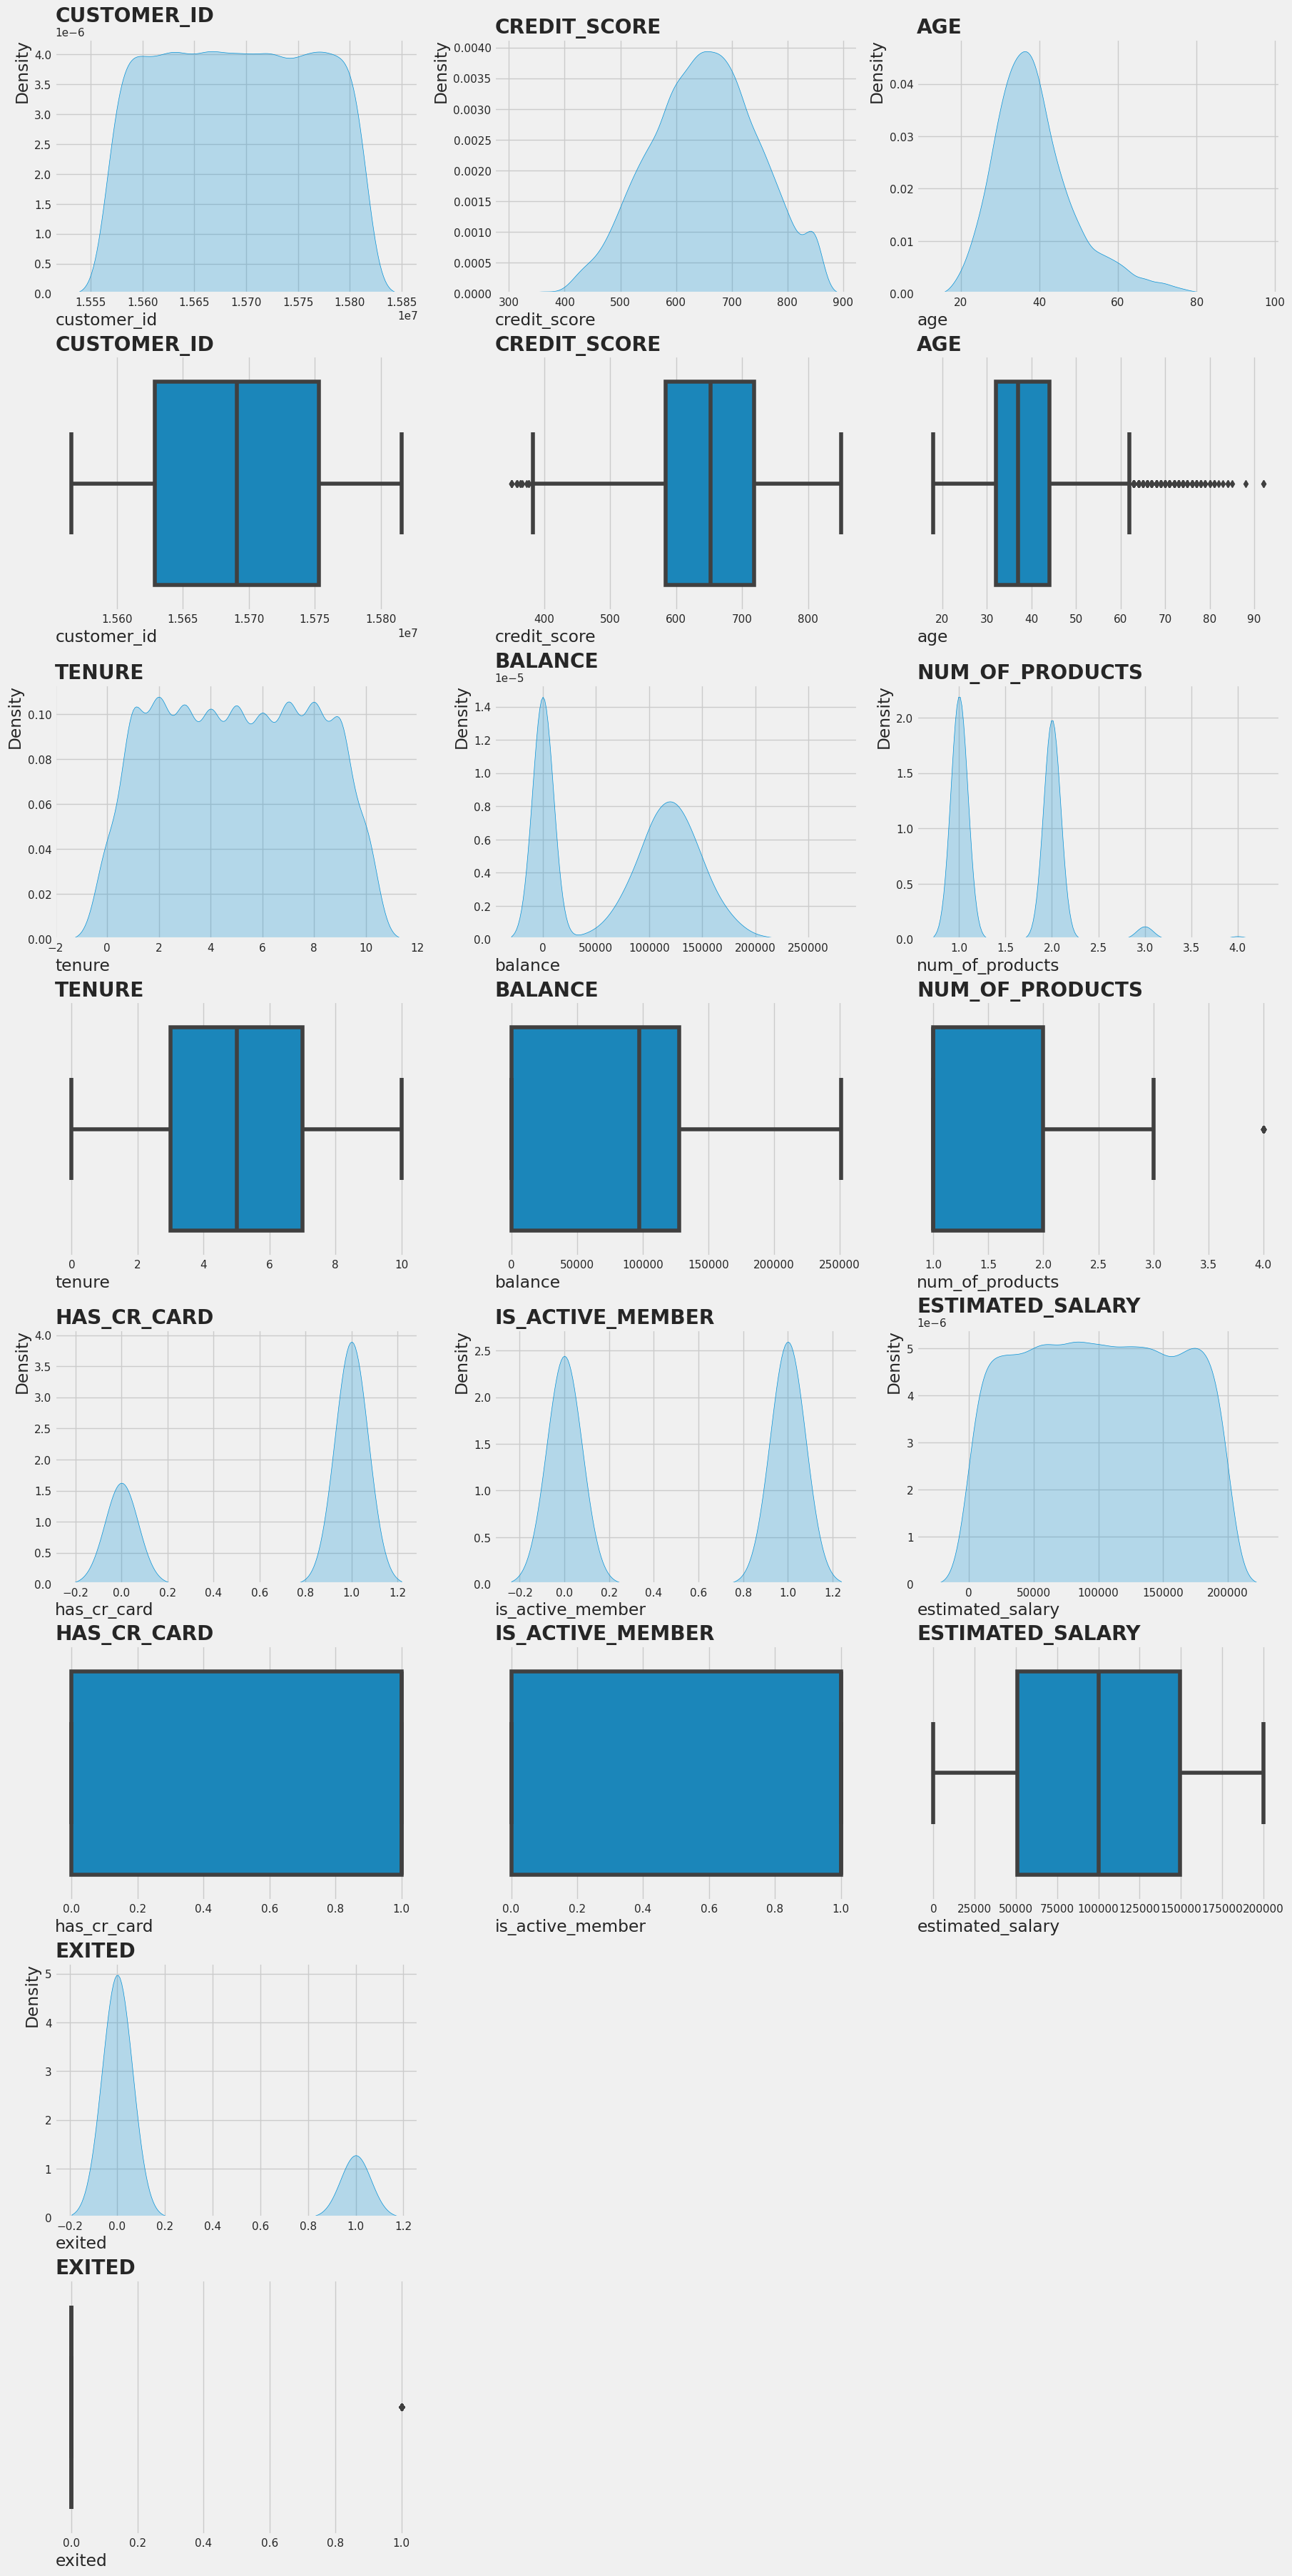

In [33]:
# plot numerical columns for base data
numerical_plot(df_eda_num, hist=False)

### 5.2.2 - Categorical Columns

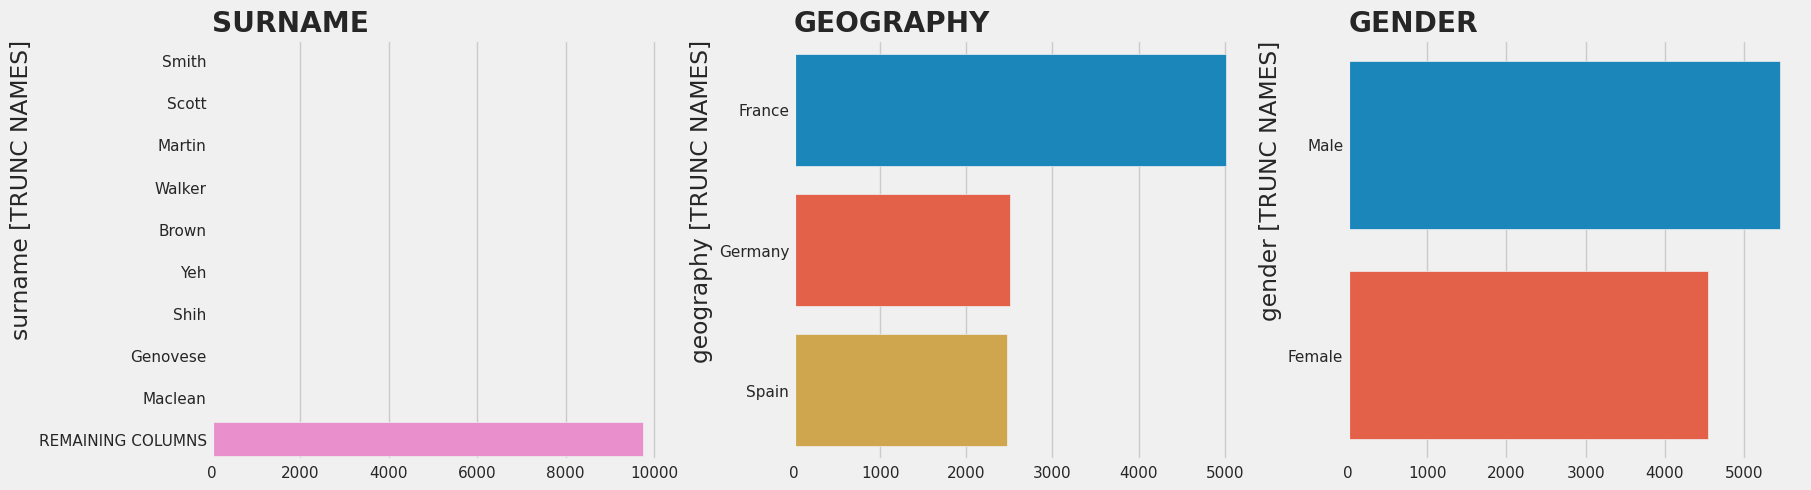

In [34]:
# plot categorical columns for base data
categorical_plot(df_eda_str)

### 5.2.3 Datetime Columns

In [35]:
# # plot datetime columns for base data
# datetime_plot(df_eda_date)

# no datetime columns

## 5.3 - Bivariate Analysis

*Explore relationship between variables (in pairs)*

### 5.3.1 - Initial inspection

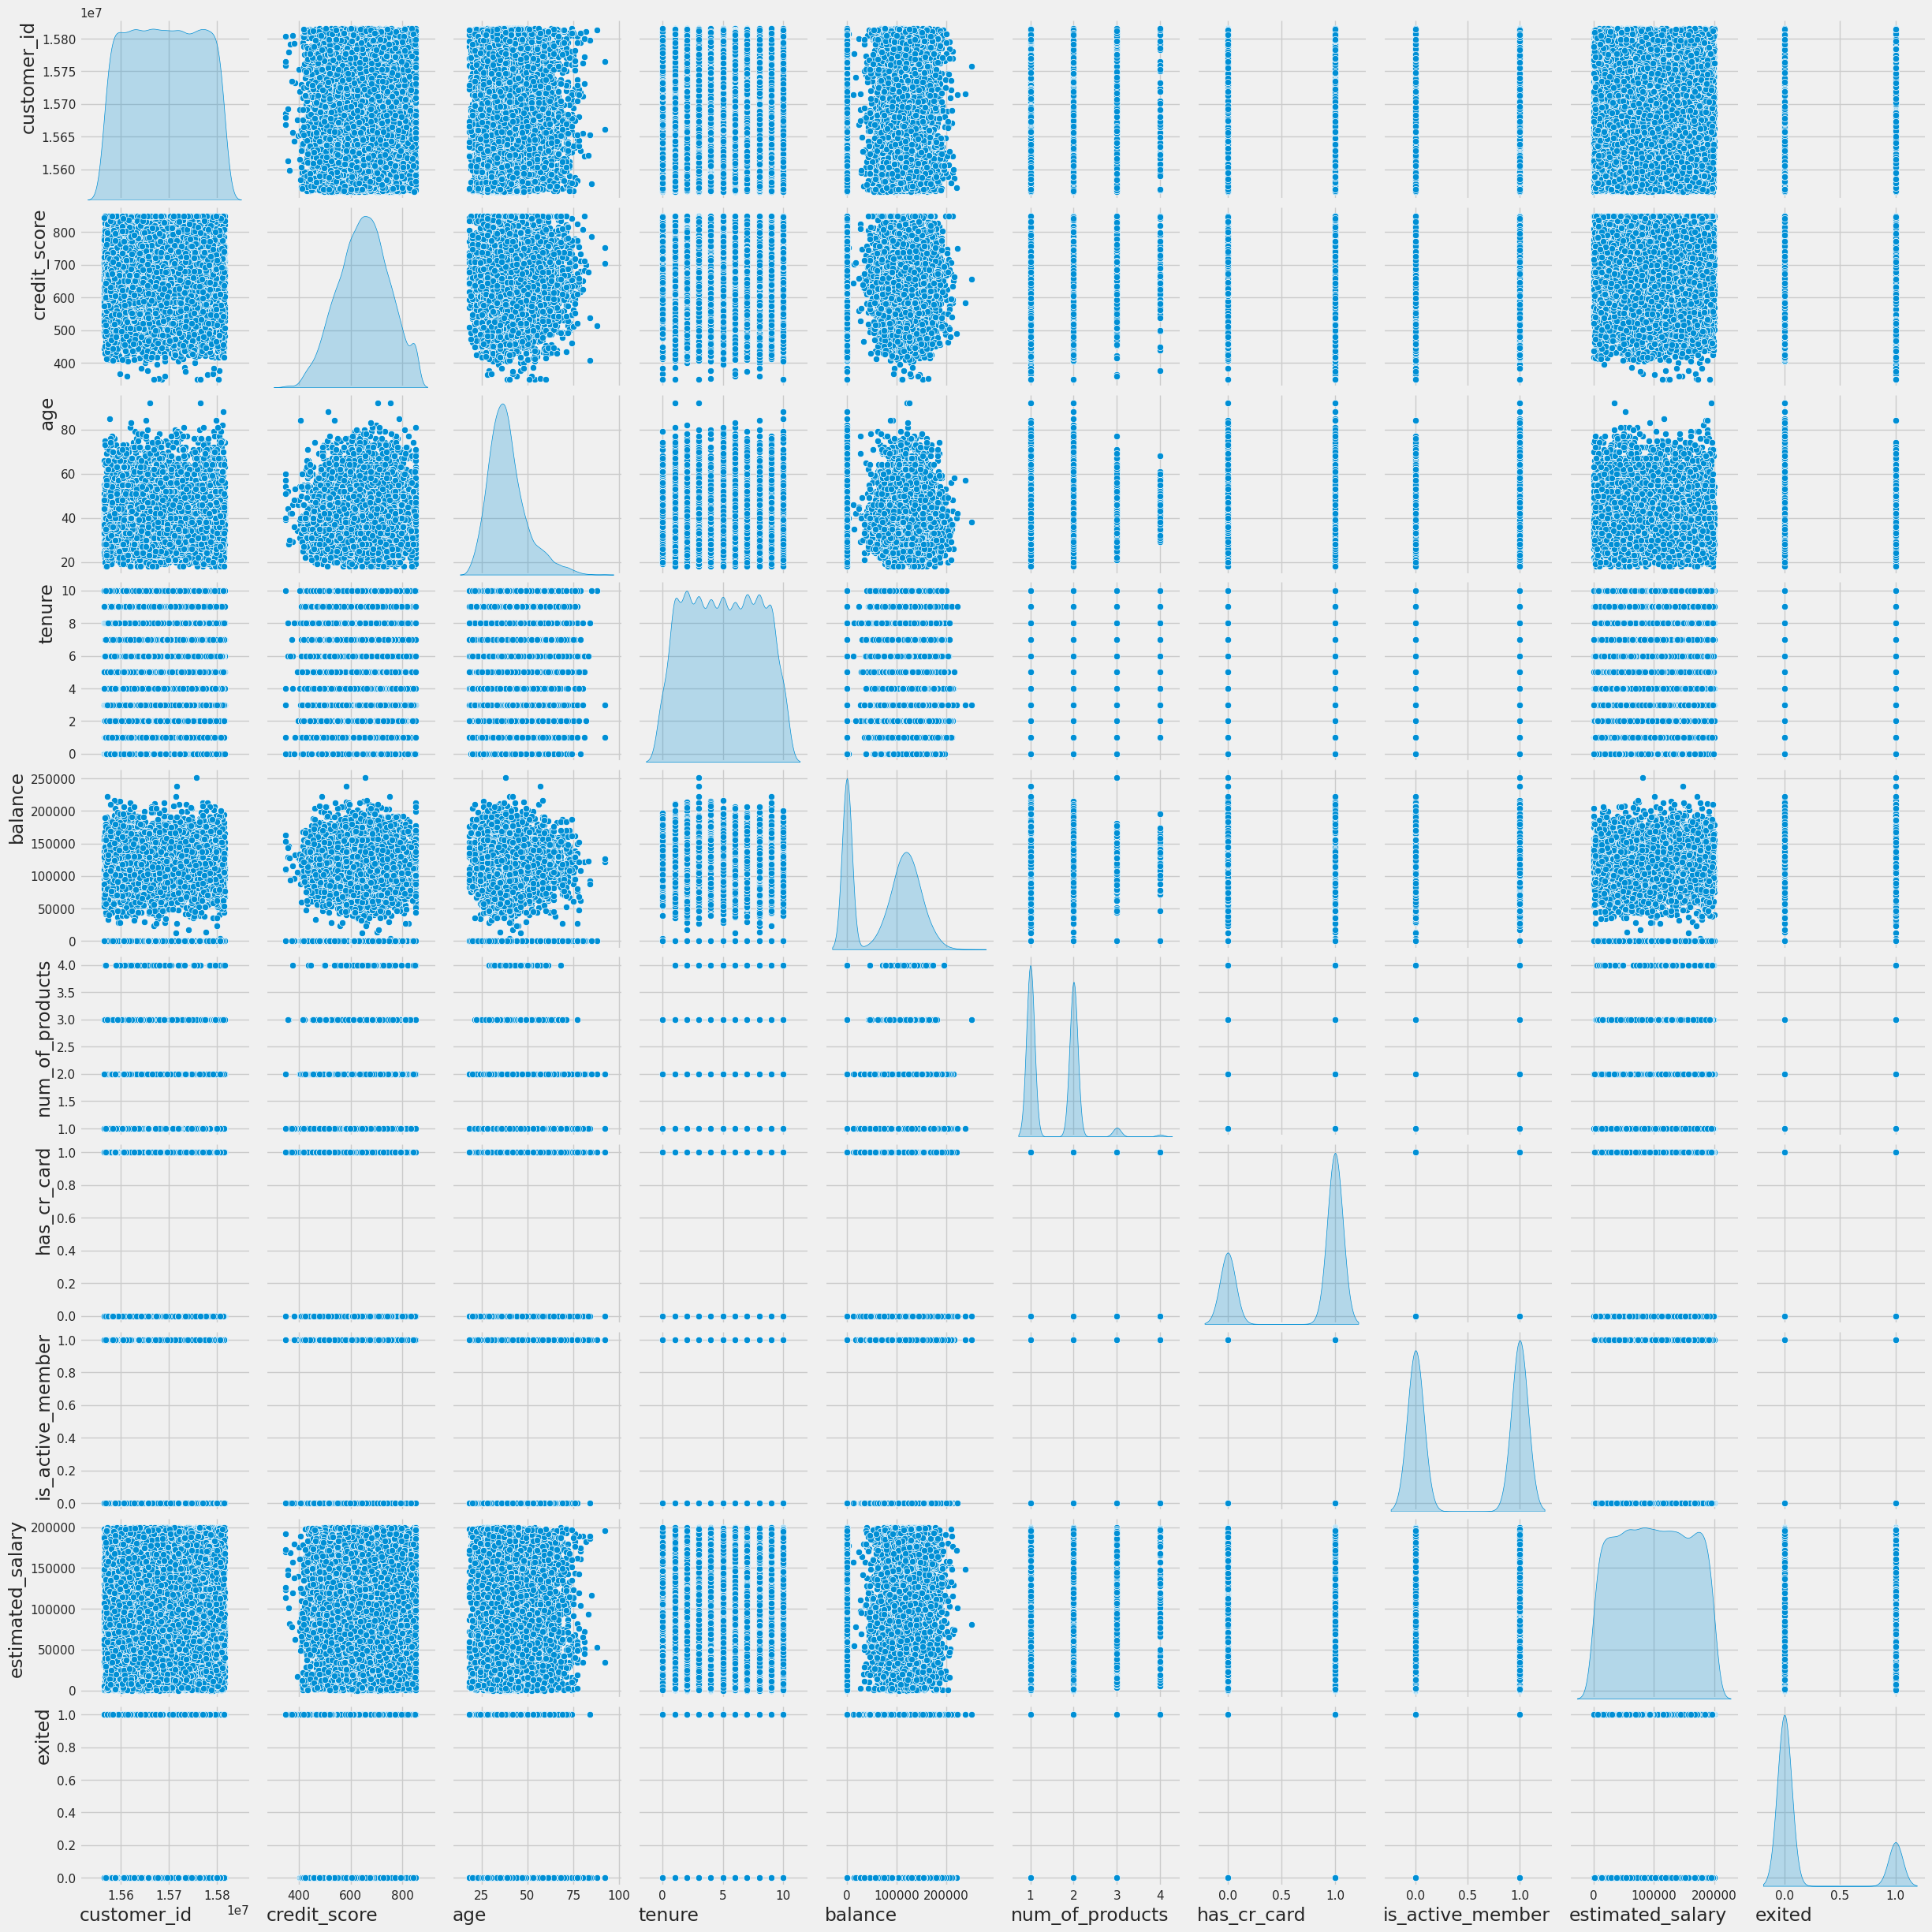

In [36]:
# plot pairplot
sns.pairplot( df_eda, diag_kind = "kde" );

### 5.3.2 - Numerical variables

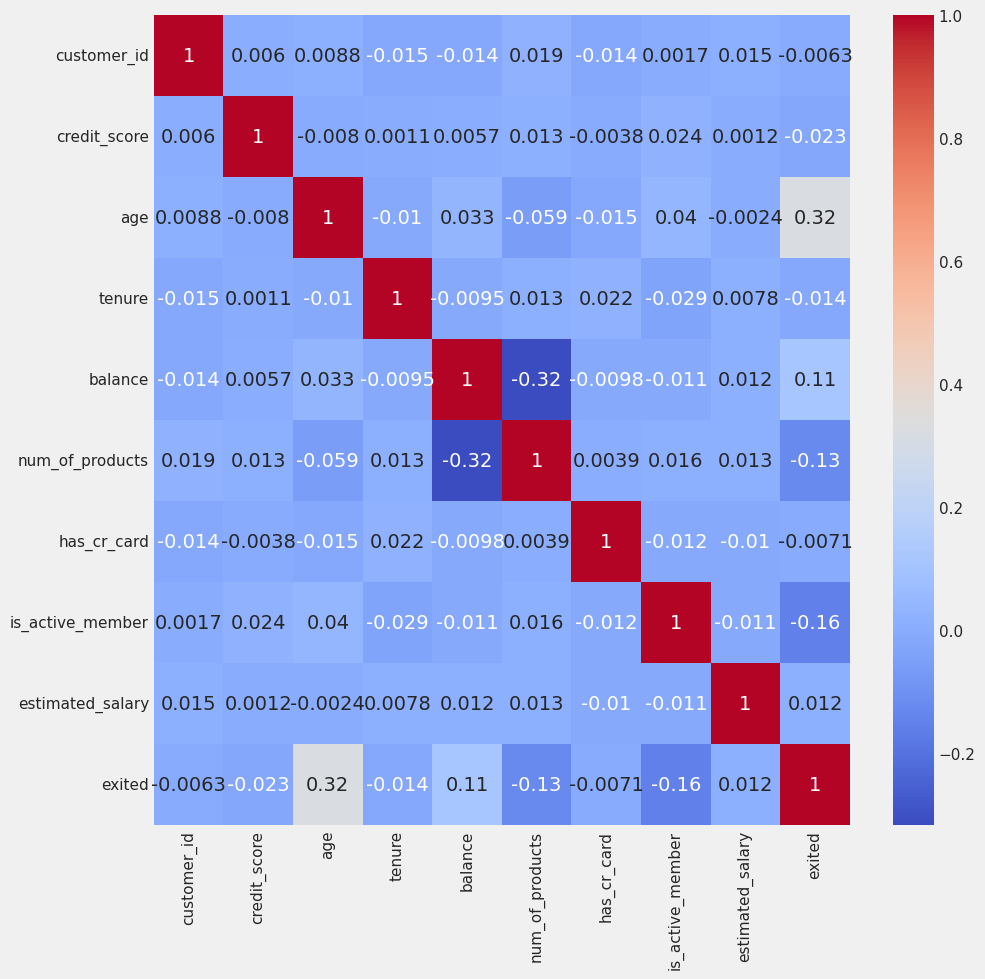

In [37]:
# calculate pearson correlation coefficient
correlation = df_eda_num.corr( method = 'spearman' )

# create figure and ax object
fig, ax = plt.subplots( figsize = (10, 10) )

# display heatmap of correlation on figure
sns.heatmap( correlation, annot = True, cmap="coolwarm", ax = ax)
plt.yticks( rotation = 0 );

### 5.3.3 - Categorical variables

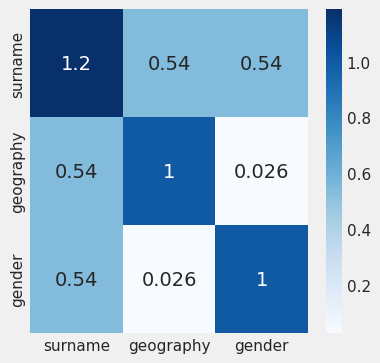

In [38]:
# create a dataframe with cramer-v for every row-column pair
cramer_v_corr = create_cramer_v_dataframe( df_eda_str )

# create figure and ax object
fig, ax = plt.subplots( figsize = (4, 4) )

# display heatmap of correlation on figure
sns.heatmap( cramer_v_corr, annot = True, cmap="Blues", ax = ax);

## 5.4 - Business Hypothesis

*Validate all business hypothesis based on available data*

In [39]:
# No hypothesis was raised

## 5.5 - Data Space Analysis

**Initial inspection on dimensionality reduction potential**

### PCA

In [40]:
# no need up this first project iteration

### UMAP

In [41]:
# no need up this first project iteration

### t-SNE

In [42]:
# no need up this first project iteration

### PHATE

In [43]:
# no need up this first project iteration

### Tree-Base Embedding

In [44]:
# no need up this first project iteration

### KMeans Embedding

In [45]:
# no need up this first project iteration

# **6 - DATA PREPARATION**

## 6.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [46]:
# create a restore point for the previous section dataframe
df_prep = df_eda.copy()

# check dataframe
check_dataframe( df_prep )

*************************************************
Dataframe size in memory: 2.684 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
customer_id,0,0,10.000,int64
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64
has_cr_card,0,0,2,int64


-----------------------------

 Dataframe shape is (10000, 13) 

-----------------------------


dataframe.sample(5)


,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
8287,15682467,Chimezie,725,France,Female,36,1,"118,851.1",1,1,1,"102,747.0",0
8151,15750970,Davidson,500,Spain,Male,40,1,"99,004.2",1,1,1,"152,846.0",0
7900,15653275,Lei,785,Spain,Female,54,1,0.0,2,1,0,"45,113.9",1
4421,15698758,Onwuamaegbu,630,Spain,Female,31,1,0.0,2,1,1,"169,802.7",0
3258,15577514,Mai,698,Germany,Female,36,7,"121,263.6",1,1,1,"13,387.9",0


*************************************************


## 6.2 - Remove variables that won't be available in the production environment

*Remove variables that model can use on production to make predictions*

In [47]:
# sanity check
assert df_prep["customer_id"].nunique() == len(df_prep), "customer_id is not dataframe granularity"

# remove customer_id column
df_prep = df_prep.drop(columns=["customer_id"])

# inspect results
df_prep


,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,Hargrave,619,France,Female,42,2,0.0,1,1,1,"101,348.9",1
1,Hill,608,Spain,Female,41,1,"83,807.9",1,0,1,"112,542.6",0
2,Onio,502,France,Female,42,8,"159,660.8",3,1,0,"113,931.6",1
3,Boni,699,France,Female,39,1,0.0,2,0,0,"93,826.6",0
4,Mitchell,850,Spain,Female,43,2,"125,510.8",1,1,1,"79,084.1",0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Obijiaku,771,France,Male,39,5,0.0,2,1,0,"96,270.6",0
9996,Johnstone,516,France,Male,35,10,"57,369.6",1,1,1,"101,699.8",0
9997,Liu,709,France,Female,36,7,0.0,1,0,1,"42,085.6",1
9998,Sabbatini,772,Germany,Male,42,3,"75,075.3",2,1,0,"92,888.5",1


## 6.3 - Train-Validation-Test split

*Split dataframe into training, validation and test dataset*

In [48]:
# split data into X and y
X = df_prep.drop(columns=["exited"])
y = df_prep["exited"]

# inspect results
display("X", X, "y", y)

'X'

,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,Hargrave,619,France,Female,42,2,0.0,1,1,1,"101,348.9"
1,Hill,608,Spain,Female,41,1,"83,807.9",1,0,1,"112,542.6"
2,Onio,502,France,Female,42,8,"159,660.8",3,1,0,"113,931.6"
3,Boni,699,France,Female,39,1,0.0,2,0,0,"93,826.6"
4,Mitchell,850,Spain,Female,43,2,"125,510.8",1,1,1,"79,084.1"
...,...,...,...,...,...,...,...,...,...,...,...
9995,Obijiaku,771,France,Male,39,5,0.0,2,1,0,"96,270.6"
9996,Johnstone,516,France,Male,35,10,"57,369.6",1,1,1,"101,699.8"
9997,Liu,709,France,Female,36,7,0.0,1,0,1,"42,085.6"
9998,Sabbatini,772,Germany,Male,42,3,"75,075.3",2,1,0,"92,888.5"


'y'

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: exited, Length: 10000, dtype: int64

In [49]:
# split data into train and test preserving the proportion of target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=SEED, 
                                                    shuffle=True, stratify=y)

# inspect results
display(
    "X_train", X_train, 
    "X_test", X_test, 
    "y_train", y_train, 
    "y_test", y_test,
    "len(X_test)/len(X)", len(X_test) / len(X),
    "y_train.value_counts()", y_train.value_counts(normalize=True), 
    "y_test.value_counts()", y_test.value_counts(normalize=True),
)

'X_train'

,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
3529,Ts'ui,623,France,Female,24,5,0.0,2,1,0,"116,160.0"
8131,Scott,613,Germany,Male,33,3,"155,736.4",2,1,1,"57,751.2"
2423,MacDevitt,662,France,Female,29,10,0.0,2,1,0,"137,508.3"
7466,Brodney,700,Germany,Female,30,4,"116,377.5",1,1,1,"134,417.3"
6425,Gray,793,France,Male,39,3,"137,817.5",1,0,0,"83,997.8"
...,...,...,...,...,...,...,...,...,...,...,...
8309,Bellasis,749,France,Female,27,9,0.0,2,1,0,"132,734.9"
6539,Johnson,697,France,Female,45,1,0.0,2,1,0,"46,807.6"
6695,Sabbatini,646,France,Female,33,2,0.0,2,0,0,"198,208.0"
6572,Hsueh,588,France,Female,21,8,0.0,2,1,1,"110,114.2"


'X_test'

,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
7545,Welsh,732,France,Male,26,7,0.0,2,1,0,"154,364.7"
6136,Serena,780,Spain,Female,33,6,"145,580.6",1,1,1,"154,598.6"
7844,Allen,612,France,Female,38,1,0.0,2,1,1,"9,209.2"
4420,Toscani,714,Germany,Female,35,6,"126,077.4",2,1,1,"53,954.2"
1187,Brennan,765,France,Female,50,9,"126,547.8",1,1,1,"79,579.9"
...,...,...,...,...,...,...,...,...,...,...,...
5520,Walker,570,France,Female,61,6,"142,105.4",1,1,1,"45,214.0"
7557,Chin,426,France,Male,34,9,0.0,2,1,0,"107,876.9"
6530,Bufkin,511,Germany,Female,75,9,"105,609.2",1,0,1,"105,425.2"
2812,Franklin,597,France,Male,28,2,0.0,3,1,1,"78,708.0"


'y_train'

3529    0
8131    0
2423    0
7466    0
6425    0
       ..
8309    0
6539    1
6695    0
6572    0
2170    0
Name: exited, Length: 7000, dtype: int64

'y_test'

7545    0
6136    0
7844    0
4420    0
1187    1
       ..
5520    0
7557    0
6530    0
2812    0
4216    0
Name: exited, Length: 3000, dtype: int64

'len(X_test)/len(X)'

0.3

'y_train.value_counts()'

exited
0   0.8
1   0.2
Name: proportion, Length: 2, dtype: float64

'y_test.value_counts()'

exited
0   0.8
1   0.2
Name: proportion, Length: 2, dtype: float64

## 6.4 - Scale numeric features

*Scale numeric feature to make modelling "easier" for ML models*

### 6.4.1 - Standard Scaler

**Best use case:**
- numerical feature with a normal distribution and few or no outliers

In [50]:
# at first, no feature fits this condition

### 6.4.2 - Min-Max Scaler

**Best use case:**
- numerical feature with a skewed distribution and few or no outliers

In [51]:
# define min-max cols according to exploratory analysis and best use case
min_max_cols = ["tenure", "balance", "num_of_products", "estimated_salary"]

### 6.4.3 - Robust Scaler

**Best use case:**
- numerical feature with many outliers


In [52]:
# define robust scaler cols according to exploratory analysis and best use case
robust_scaler_cols = ["credit_score", "age", ]

### 6.4.4 - Discretization

In [53]:
# no need up this first project iteration

## 6.5 - Encode categorical features

*Encode categorical feature to make modelling possible for ML models*

### 6.5.1 - One-Hot Encoding

In [54]:
# define one-hot encoding cols according to exploratory analysis and best use case
ohe_cols = ["geography", "gender", "has_cr_card", "is_active_member"]

### 6.5.2 - Ordinal Encoding

In [55]:
# no need up this first project iteration

### 6.5.3 - Target Encoding

In [56]:
# no need up this first project iteration

## 6.6 - Response variable transformation

*Transform target variable (e.g. log, sqrt, etc) to make modelling "easier" for ML models*

In [57]:
# no need ---> already 0 or 1

## 6.7 - Cyclic variables transformation

*Transform cyclic variables (e.g. days of week, months in year, etc) with a sin and cos functions*

In [58]:
# no need ---> no time-related features

## 6.8 - Double-check preparation

*Double-check the prepared dataset to make sure it is as expected*

In [59]:
# inspect X features
df_prep[min_max_cols + robust_scaler_cols + ohe_cols + ["exited"]]

,tenure,balance,num_of_products,estimated_salary,credit_score,age,geography,gender,has_cr_card,is_active_member,exited
0,2,0.0,1,"101,348.9",619,42,France,Female,1,1,1
1,1,"83,807.9",1,"112,542.6",608,41,Spain,Female,0,1,0
2,8,"159,660.8",3,"113,931.6",502,42,France,Female,1,0,1
3,1,0.0,2,"93,826.6",699,39,France,Female,0,0,0
4,2,"125,510.8",1,"79,084.1",850,43,Spain,Female,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,5,0.0,2,"96,270.6",771,39,France,Male,1,0,0
9996,10,"57,369.6",1,"101,699.8",516,35,France,Male,1,1,0
9997,7,0.0,1,"42,085.6",709,36,France,Female,0,1,1
9998,3,"75,075.3",2,"92,888.5",772,42,Germany,Male,1,0,1


# **7 - FEATURE SELECTION**

## 7.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [60]:
# create a restore point for the previous section dataframe
df_f_selection = df_prep.copy()

# check dataframe
check_dataframe( df_f_selection )

*************************************************
Dataframe size in memory: 2.604 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64
has_cr_card,0,0,2,int64
is_active_member,0,0,2,int64


-----------------------------

 Dataframe shape is (10000, 12) 

-----------------------------


dataframe.sample(5)


,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2892,Chidubem,601,France,Male,44,3,0.0,2,1,0,"30,607.1",0
1262,Chung,665,Spain,Female,40,1,"173,432.5",1,0,1,"116,766.8",0
335,Hsueh,485,France,Male,29,7,"182,123.8",1,1,0,"116,828.5",1
9815,Chinonyelum,604,France,Male,34,7,0.0,2,1,1,"188,078.5",0
66,Brownless,581,Germany,Female,34,1,"101,633.0",1,1,0,"110,431.5",0


*************************************************


*Define pipeline that will be used for moelling*

In [61]:
# define preprocessing pipeline for numerical features
rs_transformer = Pipeline([
    ("rs", RobustScaler(
        with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True, unit_variance=False
        )
    )
])
mm_transformer = Pipeline([
    ("mm", MinMaxScaler(
        feature_range=(0, 1), copy=True, clip=False
        )
    )
])

# define preprocessing pipeline for categorical features
cat_transformer = Pipeline([
    ("ohe", OneHotEncoder(
        categories='auto', drop="if_binary", sparse_output=False, dtype=int, handle_unknown='ignore'
        )
    )
])

# define pipeline depending on column type
preprocessing_f_selection = ColumnTransformer([
    ("rs_transformer", rs_transformer, robust_scaler_cols),
    ("mm_transformer", mm_transformer, min_max_cols),
    ("cat_transformer", cat_transformer, ohe_cols)
    ], remainder="drop", n_jobs=-1, 
)

# inspect pipeline
preprocessing_f_selection

ColumnTransformer(n_jobs=-1,
                  transformers=[('rs_transformer',
                                 Pipeline(steps=[('rs', RobustScaler())]),
                                 ['credit_score', 'age']),
                                ('mm_transformer',
                                 Pipeline(steps=[('mm', MinMaxScaler())]),
                                 ['tenure', 'balance', 'num_of_products',
                                  'estimated_salary']),
                                ('cat_transformer',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['geography', 'gender', 'has_cr_card',
                                  'is_active_member'])])

In [62]:
# fit preprocessing pipeline to data
preprocessing_f_selection.fit(
    X=df_f_selection.drop(columns=["exited"]), 
    y=df_f_selection["exited"]
    )

# created preprocessed dataframe
df_preprocessed_f_selection = pd.DataFrame(
    data=preprocessing_f_selection.transform(X=df_f_selection),
    columns=preprocessing_f_selection.get_feature_names_out()
    )

# sanity check
assert df_preprocessed_f_selection.shape[0] == df_f_selection.shape[0], "Using pipelines incorrectly!"

# inspect dataframe
df_preprocessed_f_selection

,rs_transformer__credit_score,rs_transformer__age,mm_transformer__tenure,mm_transformer__balance,mm_transformer__num_of_products,mm_transformer__estimated_salary,cat_transformer__geography_France,cat_transformer__geography_Germany,cat_transformer__geography_Spain,cat_transformer__gender_Male,cat_transformer__has_cr_card_1,cat_transformer__is_active_member_1
0,-0.2,0.4,0.2,0.0,0.0,0.5,1.0,0.0,0.0,0.0,1.0,1.0
1,-0.3,0.3,0.1,0.3,0.0,0.6,0.0,0.0,1.0,0.0,0.0,1.0
2,-1.1,0.4,0.8,0.6,0.7,0.6,1.0,0.0,0.0,0.0,1.0,0.0
3,0.4,0.2,0.1,0.0,0.3,0.5,1.0,0.0,0.0,0.0,0.0,0.0
4,1.5,0.5,0.2,0.5,0.0,0.4,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.9,0.2,0.5,0.0,0.3,0.5,1.0,0.0,0.0,1.0,1.0,0.0
9996,-1.0,-0.2,1.0,0.2,0.0,0.5,1.0,0.0,0.0,1.0,1.0,1.0
9997,0.4,-0.1,0.7,0.0,0.0,0.2,1.0,0.0,0.0,0.0,0.0,1.0
9998,0.9,0.4,0.3,0.3,0.3,0.5,0.0,1.0,0.0,1.0,1.0,0.0


## 7.2 - Logist regression coefficients

In [63]:
# instanciate LR
lr = LogisticRegression(n_jobs=-1, max_iter=1000, random_state=SEED)

# fit model to data
lr.fit(df_preprocessed_f_selection, df_f_selection["exited"])

LogisticRegression(max_iter=1000, n_jobs=-1, random_state=7)

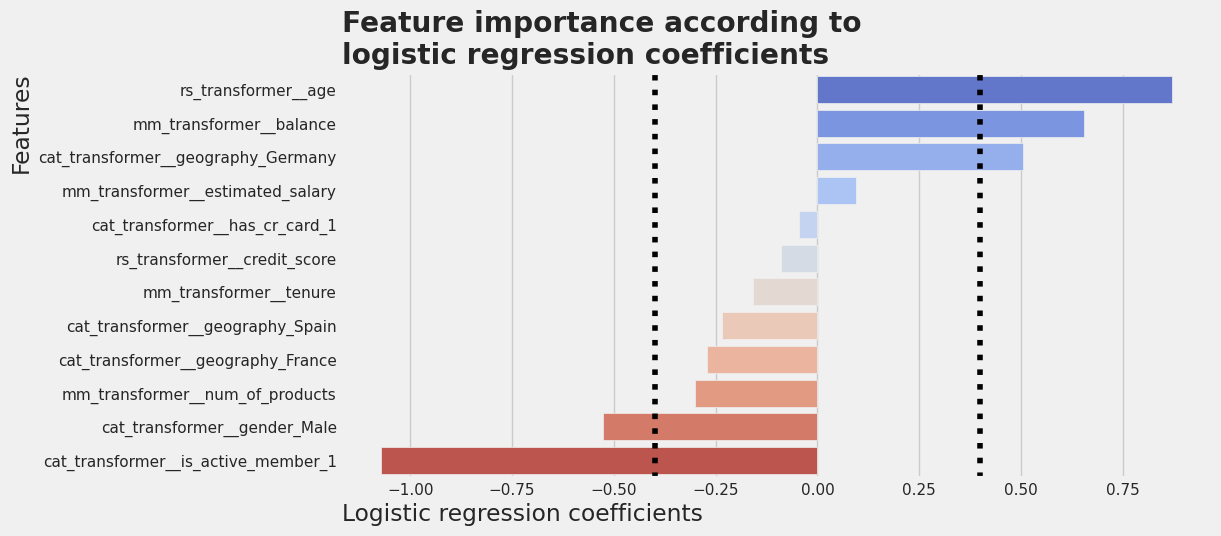

In [64]:
# create a dataframe with feature importances
df_f_coef = pd.DataFrame(data=lr.coef_, columns=df_preprocessed_f_selection.columns).T
# reset index and rename column
df_f_coef = df_f_coef.reset_index()
df_f_coef = df_f_coef.rename(columns={"index":"features", 0:"feature_coef"})
# create a new column with absolute value of coef
df_f_coef["abs_coef"] = df_f_coef["feature_coef"].apply(lambda x: abs(x))
# define column names
df_f_coef = df_f_coef.sort_values(by="feature_coef", ascending=False, ignore_index=True)

# define threshold
threshold = 0.4

# plot
sns.barplot(data=df_f_coef, x="feature_coef", y="features", palette="coolwarm")
# define details
plt.title("Feature importance according to \nlogistic regression coefficients", loc="left")
plt.ylabel("Features", loc="top")
plt.xlabel("Logistic regression coefficients", loc="left")
plt.axvline(-threshold, linestyle=":", color="black")
plt.axvline(threshold, linestyle=":", color="black")
plt.show()

In [65]:
# get features whose abs coef is > 0.4
# 0.4 was chosen using the elbow method approach
f_selected_lr = ["age", "balance", "geography", "gender", "is_active_member"]

## 7.3 - Random forest feature importance

In [66]:
# define model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight=None, random_state=SEED)

# fit model to data
rf.fit(df_preprocessed_f_selection, df_f_selection["exited"])

RandomForestClassifier(n_jobs=-1, random_state=7)

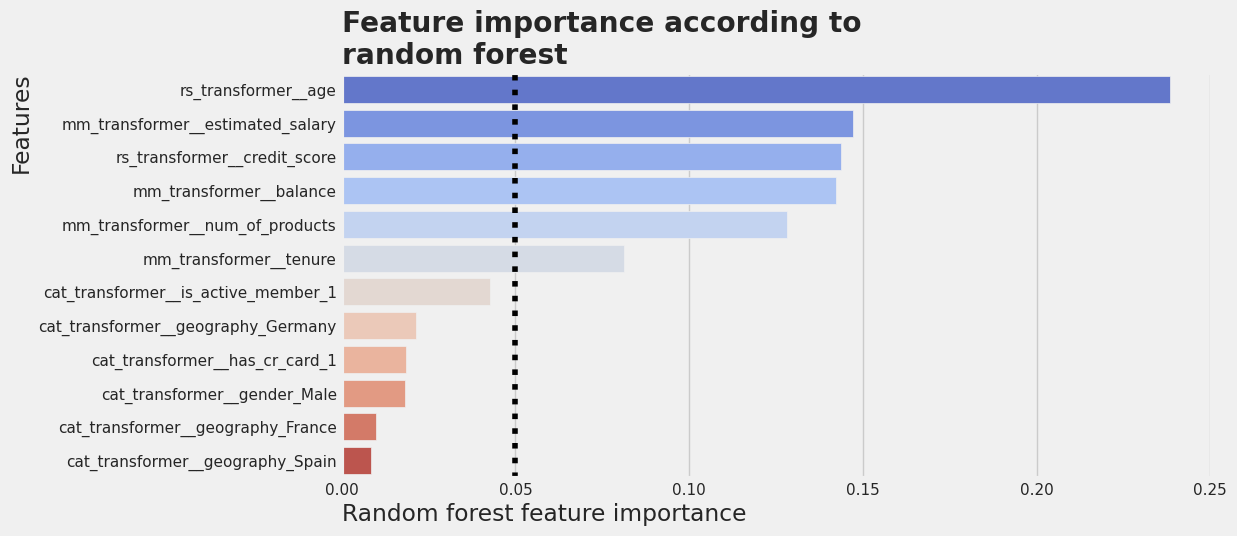

In [67]:
# create a dataframe with feature importances
df_f_importance = pd.DataFrame(data=rf.feature_importances_, index=df_preprocessed_f_selection.columns)
# reset index and rename column
df_f_importance = df_f_importance.reset_index()
df_f_importance = df_f_importance.rename(columns={"index":"features", 0:"feature_importance"})
# define column names
df_f_importance = df_f_importance.sort_values(by="feature_importance", ascending=False)

# define threshold
threshold = 0.05

# plot
sns.barplot(data=df_f_importance, x="feature_importance", y="features", palette="coolwarm")
# define details
plt.title("Feature importance according to \nrandom forest", loc="left")
plt.ylabel("Features", loc="top")
plt.xlabel("Random forest feature importance", loc="left")
plt.axvline(threshold, linestyle=":", color="black")
plt.show()

In [68]:
# get features whose feature_importance is > 0.05
# 0.05 was chosen using the elbow method approach
f_selected_rf = ["age", "salary", "credit_score", "balance", "num_of_products", "tenure"]

## 7.5 - Mutual information

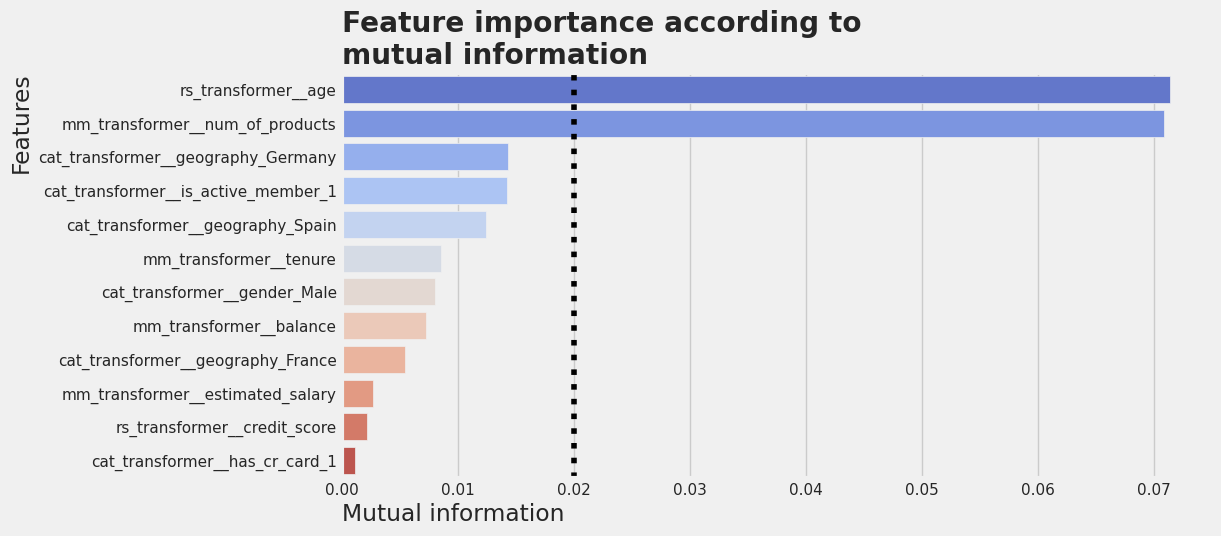

In [69]:
# calculate mutual information between features and target
mutual_info = mutual_info_classif(
    X=df_preprocessed_f_selection, 
    y=df_f_selection["exited"], 
    random_state=SEED)

# create a series from mutual information
mutual_info_series = pd.Series(mutual_info)
# add column labels as index
mutual_info_series.index=df_preprocessed_f_selection.columns
# sort in descending order
mutual_info_series = mutual_info_series.sort_values(ascending=False)

# define threshold
threshold = 0.02

# plot
sns.barplot(y=mutual_info_series.index, x=mutual_info_series, palette="coolwarm")
# define details
plt.title("Feature importance according to \nmutual information", loc="left")
plt.ylabel("Features", loc="top")
plt.xlabel("Mutual information", loc="left")
plt.axvline(threshold, linestyle=":", color="black")
plt.show()

In [70]:
# get features whose mutual_info_series > 0.02
# 0.02 was chosen more or less using the elbow method approach
f_selected_mi = ["age", "num_of_products"]

# **8 - ML MODEL TRAINING**

## 8.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [71]:
# create a restore point for the previous section dataframe
df_train = df_f_selection.copy()

# check dataframe
check_dataframe( df_train )

*************************************************
Dataframe size in memory: 2.604 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64
has_cr_card,0,0,2,int64
is_active_member,0,0,2,int64


-----------------------------

 Dataframe shape is (10000, 12) 

-----------------------------


dataframe.sample(5)


,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
5118,Kennedy,721,France,Male,40,3,0.0,1,1,1,"144,874.7",0
8939,Jenks,772,France,Male,34,9,0.0,2,1,0,"170,980.9",0
4619,Izmailova,708,France,Female,47,0,"126,589.1",2,0,1,"132,730.1",1
9164,Berry,680,Spain,Male,36,7,0.0,2,1,0,"20,109.2",0
8076,Rowland,732,France,Female,36,9,0.0,1,0,0,"3,749.0",1


*************************************************


## 8.2 - Metrics

*Define the metric of success and the health metrics*

**Principal metric**:

    - precision-recall-auc

**Health metrics**:

    - roc-auc
    - f1
    - recall
    - precision
    - accuracy
    - logloss

In [72]:
# define precision-recall auc metric for cv
precision_recall_auc = make_scorer(
    score_func=make_scorer_precision_recall_auc_,
    greater_is_better=True, 
    needs_proba=True, 
    needs_threshold=False
    )

# define metrics
metrics = {
    "PRAuc": precision_recall_auc,
    "ROC": "roc_auc", 
    "F1": "f1", 
    "Recall": "recall", 
    "Precision": "precision", 
    "Accuracy": "accuracy", 
    "NegCrossEntropy": "neg_log_loss", 
}


## 8.3 - Baseline model

*Check the performance metrics with a dummy model to get the baseline metric*

In [73]:
# DummyClassifier( strategy="most_frequent" )

## 8.4 - ML models

*Get performance metrics of ML model with cross-validation*

### 8.4.1 - Default models

In [74]:
# # define default params for model instanciation
# models_to_try = {
#     "dummy": (
#         DummyClassifier, 
#         dict(
#             strategy="most_frequent", 
#             random_state=SEED
#             )
#     ),
#     "lr": (
#         LogisticRegression,
#         dict(
#             n_jobs=-1, 
#             max_iter=1000, 
#             random_state=SEED
#             )
#     ),
#     "svm": (
#         SVC,
#         dict(
#             probability=True, 
#             max_iter=1000, 
#             random_state=SEED
#         )
#     ), 
#     "bayes": (
#         BernoulliNB,
#         dict(),
#     ),
#     "knn": (
#         KNeighborsClassifier,
#         dict(
#             n_jobs=-1
#             )
#     ),
#     "rf": (
#         RandomForestClassifier,
#         dict(
#             n_jobs=-1, 
#             random_state=SEED
#             )
#     ),
#     "lgbm": (
#         LGBMClassifier,
#         dict(
#             n_jobs=-1, 
#             random_state=SEED
#             )
#     )
# }


# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_exploration_default_models"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_exploration_default_models"
#         ).experiment_id


# # iterate over models to test
# for model_tag in models_to_try.keys():
#     # print report
#     print(f"On model {model_tag.upper()} 🚀")

#     # define preprocessing pipeline for numerical features
#     rs_transformer = Pipeline([
#         ("rs", RobustScaler(
#             with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True, unit_variance=False
#             )
#         )
#     ])
#     mm_transformer = Pipeline([
#         ("mm", MinMaxScaler(
#             feature_range=(0, 1), copy=True, clip=False
#             )
#         )
#     ])

#     # define preprocessing pipeline for categorical features
#     cat_transformer = Pipeline([
#         ("ohe", OneHotEncoder(
#             categories='auto', drop="if_binary", sparse_output=False, dtype=int, handle_unknown='ignore'
#             )
#         )
#     ])

#     # define pipeline depending on column type
#     preprocessing = ColumnTransformer([
#         ("rs_transformer", rs_transformer, robust_scaler_cols),
#         ("mm_transformer", mm_transformer, min_max_cols),
#         ("cat_transformer", cat_transformer, ohe_cols)
#         ], remainder="drop", n_jobs=-1, 
#     )


#     # define model variable and its params
#     model = models_to_try[model_tag][0]
#     model_params = models_to_try[model_tag][1].copy()

#     # define ML model
#     ml_model = model(**model_params)

#     # add ML model to pipeline
#     pipe = Pipeline([
#         ("preprocessing", preprocessing),
#         ("ml_model", ml_model)
#     ])


#     # Cross-validate Pipeline
#     cv = cross_validate(
#         estimator=pipe, 
#         X=X_train, 
#         y=y_train, 
#         scoring=metrics,
#         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
#         n_jobs=-1, 
#         return_train_score=True, 
#         return_estimator=False, 
#         error_score=np.nan
#     )

#     # get cv metrics
#     cv_metrics = {metric: np.mean(cv[f'test_{metric}']) for metric in metrics}

#     # define MLFlow model tag
#     mlflow_model_tag = f"{model_tag.upper()}"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_model_tag, 
#         tags={
#             "experiment_context": "default_model_no_tunning",
#             "model": model_tag
#         }):
#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # log model name as param
#         mlflow.log_param("model", mlflow_model_tag)
#         # log metrics on MLFlow
#         mlflow.log_metrics(cv_metrics)
#         # log chosen model params
#         mlflow.log_params(model_params)

#         # check if light gbm
#         if model_tag == "lgbm": 
#             # log model
#             mlflow.lightgbm.log_model(
#                 lgb_model=pipe, 
#                 artifact_path="sklearn_model",
#                 registered_model_name= (mlflow_model_tag + "_model")
#                 )

#         # sklearn model
#         else:             
#             # log model
#             mlflow.sklearn.log_model(
#                 sk_model=pipe, 
#                 artifact_path="sklearn_model",
#                 registered_model_name= (mlflow_model_tag + "_model")
#                 )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged {model_tag.upper()} ✅\n")


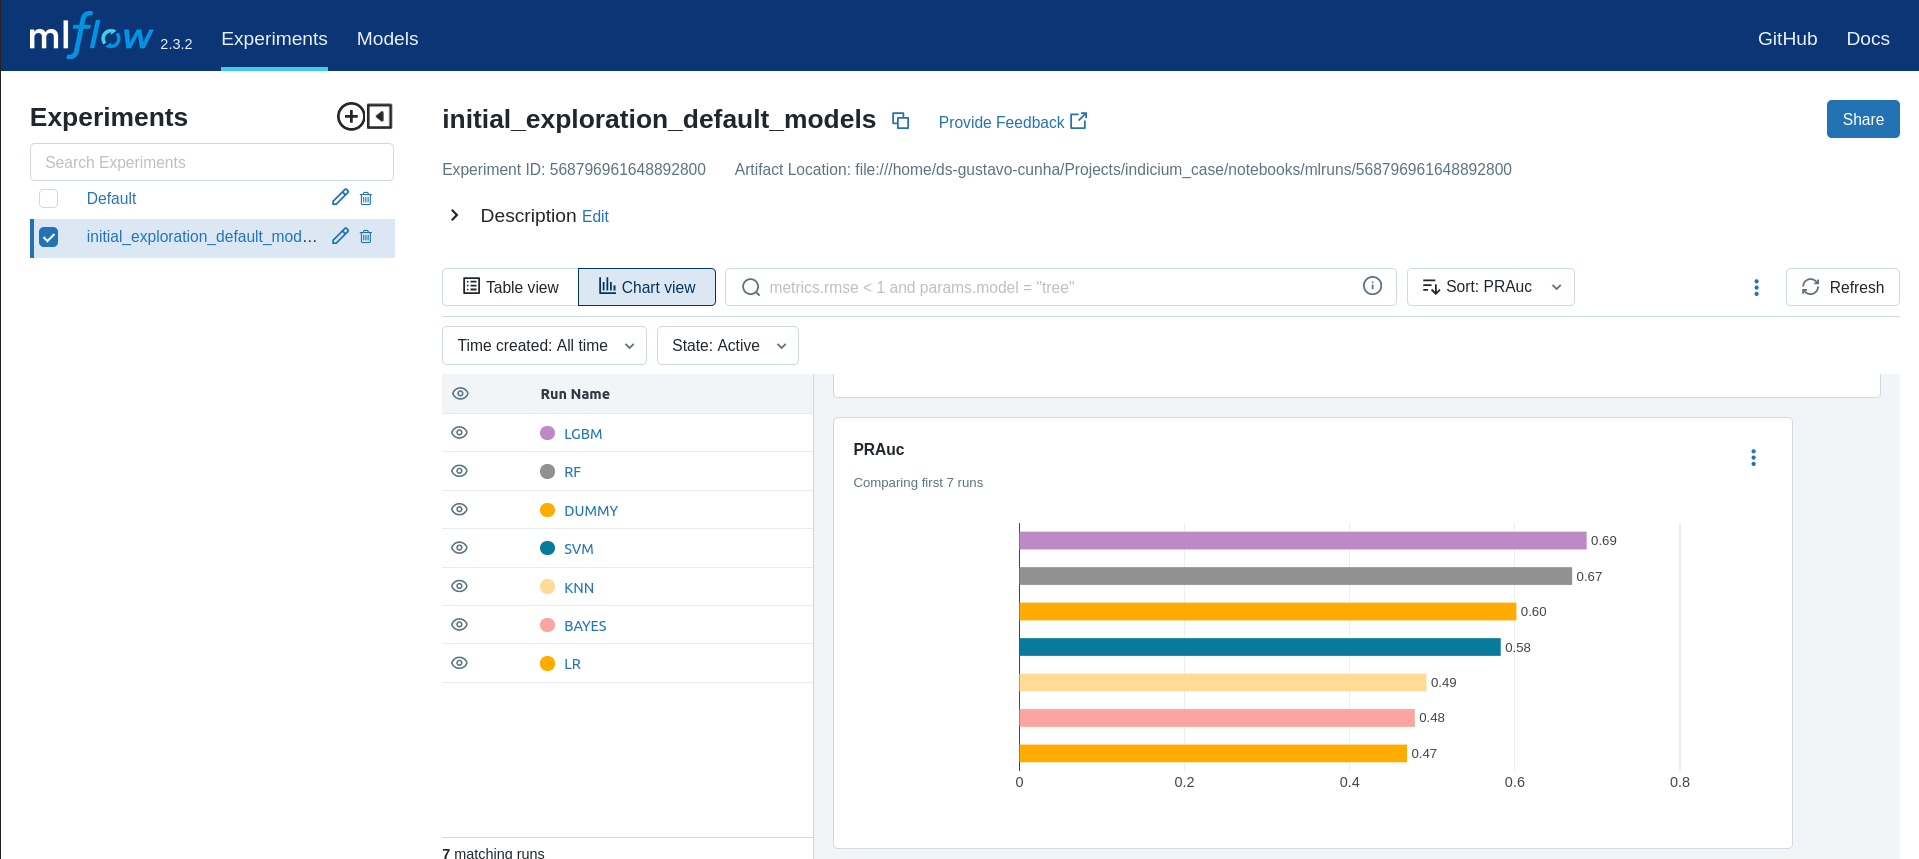

In [75]:
# display MLFlow experiment
Image.open(os.path.join("..", "img", "experiment_tracking", "initial_exploration_default_models.png"))

### 8.4.1 - Feature selection on best default models

In [76]:
# # define default params for model instanciation
# features_to_try = {
#     "all": X_train.columns,
#     "lr": f_selected_lr, 
#     "rf": f_selected_rf, 
#     "mi": f_selected_mi
#     }

# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_exploration_feature_selection"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_exploration_feature_selection"
#         ).experiment_id


# # iterate over models to test
# for features_tag in features_to_try.keys():
#     # print report
#     print(f"On features {features_tag.upper()} 🚀")

#     # define preprocessing pipeline for numerical features
#     rs_transformer = Pipeline([
#         ("rs", RobustScaler(
#             with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True, unit_variance=False
#             )
#         )
#     ])
#     mm_transformer = Pipeline([
#         ("mm", MinMaxScaler(
#             feature_range=(0, 1), copy=True, clip=False
#             )
#         )
#     ])

#     # define preprocessing pipeline for categorical features
#     cat_transformer = Pipeline([
#         ("ohe", OneHotEncoder(
#             categories='auto', drop="if_binary", sparse_output=False, dtype=int, handle_unknown='ignore'
#             )
#         )
#     ])

#     # define pipeline depending on column type
#     preprocessing = ColumnTransformer([
#         ("rs_transformer", rs_transformer, list(set(robust_scaler_cols).intersection(set(features_to_try[features_tag])))),
#         ("mm_transformer", mm_transformer, list(set(min_max_cols).intersection(set(features_to_try[features_tag])))),
#         ("cat_transformer", cat_transformer, list(set(ohe_cols).intersection(set(features_to_try[features_tag]))))
#         ], remainder="drop", n_jobs=-1, 
#     )

#     # instanciate ML model
#     ml_model = LGBMClassifier(
#             n_jobs=-1, 
#             random_state=SEED
#             )

#     # add ML model to pipeline
#     pipe = Pipeline([
#         ("preprocessing", preprocessing),
#         ("ml_model", ml_model)
#     ])

#     # Cross-validate Pipeline
#     cv = cross_validate(
#         estimator=pipe, 
#         X=X_train, 
#         y=y_train, 
#         scoring=metrics,
#         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
#         n_jobs=-1, 
#         return_train_score=True, 
#         return_estimator=False, 
#         error_score=np.nan
#     )

#     # get cv metrics
#     cv_metrics = {metric: np.mean(cv[f'test_{metric}']) for metric in metrics}

#     # define MLFlow model tag
#     mlflow_features_tag = f"{features_tag.upper()}"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_features_tag, 
#         tags={
#             "experiment_context": "best_default_model_feature_selection",
#             "model": features_tag
#         }):
#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # log model name as param
#         mlflow.log_param("features", features_to_try[features_tag])
#         # log metrics on MLFlow
#         mlflow.log_metrics(cv_metrics)

#         # log model
#         mlflow.lightgbm.log_model(
#             lgb_model=pipe, 
#             artifact_path="lgbm_model",
#             registered_model_name= (mlflow_features_tag + "_model")
#             )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged {mlflow_features_tag.upper()} ✅\n")


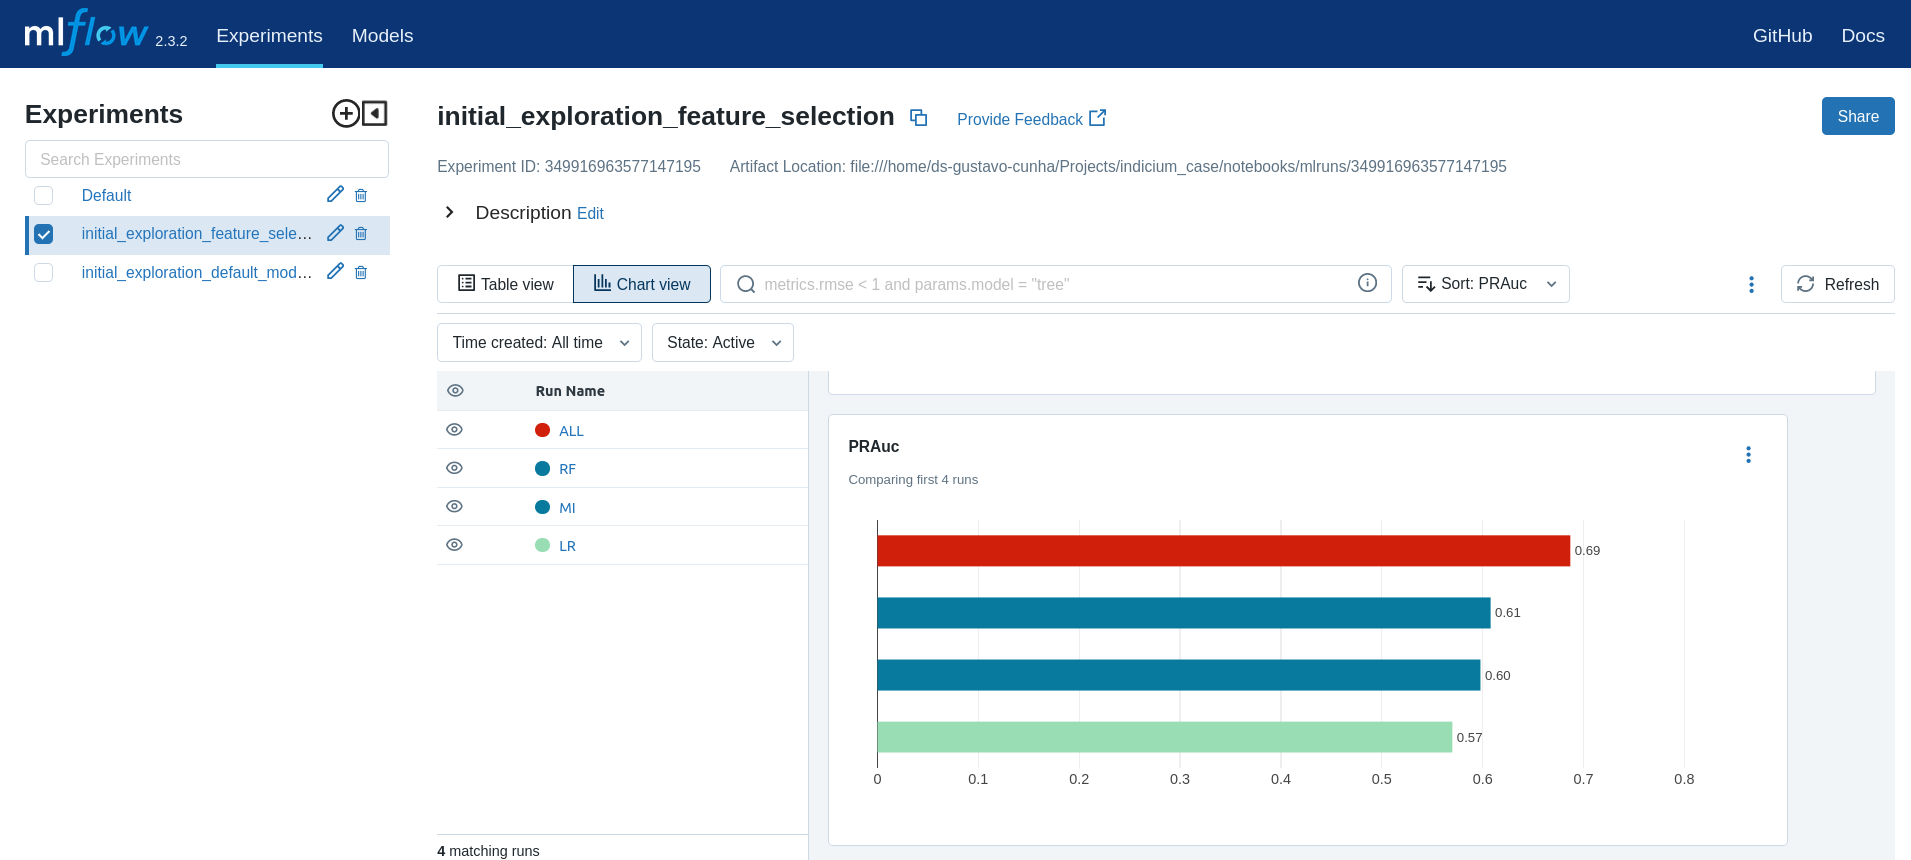

In [77]:
# display MLFlow experiment
Image.open(os.path.join("..", "img", "experiment_tracking", "initial_exploration_feature_selection.png"))

## 8.5 - Final modelling comparison

*Compare all models and decide what one is the best (and will be fine-tuned)*

In [78]:
# check two previous MLFlow prints

# **9 - HYPERPARAMETER TUNNING**

## 9.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [79]:
# create a restore point for the previous section dataframe
df_tune = df_train.copy()

# check dataframe
check_dataframe( df_tune )

*************************************************
Dataframe size in memory: 2.604 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64
has_cr_card,0,0,2,int64
is_active_member,0,0,2,int64


-----------------------------

 Dataframe shape is (10000, 12) 

-----------------------------


dataframe.sample(5)


,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
8746,Hammond,660,France,Male,34,8,"106,486.7",2,0,1,"182,262.7",0
8453,Parkes,567,France,Female,41,9,"137,891.4",1,1,0,"142,009.5",1
890,Wright,788,Spain,Male,37,8,"141,541.2",1,0,0,"66,013.3",0
4656,Fomin,843,France,Female,38,8,"134,887.5",1,1,1,"10,804.0",0
6400,Collier,676,Spain,Female,30,5,0.0,2,0,0,"179,066.6",0


*************************************************


## 9.2 - Hypertune the best ML model

*Check the best hyperparams for the best ML model*

### 9.2.1 - Grid Search

In [80]:
# Won't be used ---> take lots of time

### 9.2.2 - Random Search

In [81]:
# define preprocessing pipeline for numerical features
rs_transformer = Pipeline([
    ("rs", RobustScaler(
        with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True, unit_variance=False
        )
    )
])
mm_transformer = Pipeline([
    ("mm", MinMaxScaler(
        feature_range=(0, 1), copy=True, clip=False
        )
    )
])

# define preprocessing pipeline for categorical features
cat_transformer = Pipeline([
    ("ohe", OneHotEncoder(
        categories='auto', drop="if_binary", sparse_output=False, dtype=int, handle_unknown='ignore'
        )
    )
])

# define pipeline depending on column type
preprocessing = ColumnTransformer([
    ("rs_transformer", rs_transformer, robust_scaler_cols),
    ("mm_transformer", mm_transformer, min_max_cols),
    ("cat_transformer", cat_transformer, ohe_cols)
    ], remainder="drop", n_jobs=-1, 
)

# instanciate ML model
ml_model = LGBMClassifier(
        n_jobs=-1, 
        random_state=SEED
        )

# add ML model to pipeline
pipe = Pipeline([
    ("preprocessing", preprocessing),
    ("ml_model", ml_model)
])

# inspect pipe
pipe.get_params()

{'memory': None,
 'steps': [('preprocessing', ColumnTransformer(n_jobs=-1,
                     transformers=[('rs_transformer',
                                    Pipeline(steps=[('rs', RobustScaler())]),
                                    ['credit_score', 'age']),
                                   ('mm_transformer',
                                    Pipeline(steps=[('mm', MinMaxScaler())]),
                                    ['tenure', 'balance', 'num_of_products',
                                     'estimated_salary']),
                                   ('cat_transformer',
                                    Pipeline(steps=[('ohe',
                                                     OneHotEncoder(drop='if_binary',
                                                                   dtype=<class 'int'>,
                                                                   handle_unknown='ignore',
                                                                   sparse_output=Fa

In [82]:
# # Cross-validate Pipeline
# rs_cv = RandomizedSearchCV(
#     estimator=pipe, 
#     param_distributions=dict(
#         preprocessing__rs_transformer__rs__quantile_range = [
#             (25.0, 75.0),
#             (10.0, 90.0),
#             (05.0, 95.0)
#         ],
#         preprocessing__rs_transformer__rs__unit_variance = [True, False],
#         preprocessing__rs_transformer__rs__with_centering = [True, False],
#         preprocessing__rs_transformer__rs__with_scaling = [True, False],
#         preprocessing__mm_transformer__mm__clip = [True, False],
#         ml_model__num_leaves = [10, 31, 100],
#         ml_model__max_depth = [-1, 10, 30],
#         ml_model__learning_rate = [1, 0.3, 0.1, 0.03, 0.01],
#         ml_model__n_estimators = [30, 100, 300],
#         ml_model__class_weight = [{0:1, 1:9}, {0:2, 1:8}, {0:3, 1:7}, {0:4, 1:6}, {0:5, 1:5}],
#         ml_model__reg_alpha = [0.0, 0.3],
#         ml_model__reg_lambda = [0.0, 0.3],
#         ml_model__n_jobs = [-1],
#     ), 
#     n_iter=300, 
#     scoring=metrics, 
#     n_jobs=-1, 
#     refit="PRAuc", 
#     cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), 
#     verbose=1, 
#     random_state=SEED, 
#     error_score=np.nan, 
#     return_train_score=True
# )

# # fit grid-search to data
# rs_cv.fit(X=X_train, y=y_train)

In [83]:
# # inspect best params
# rs_cv.best_params_

In [84]:
# define best params as a variable
best_params = {'preprocessing__rs_transformer__rs__with_scaling': True,
 'preprocessing__rs_transformer__rs__with_centering': False,
 'preprocessing__rs_transformer__rs__unit_variance': False,
 'preprocessing__rs_transformer__rs__quantile_range': (25.0, 75.0),
 'preprocessing__mm_transformer__mm__clip': True,
 'ml_model__reg_lambda': 0.0,
 'ml_model__reg_alpha': 0.0,
 'ml_model__num_leaves': 10,
 'ml_model__n_jobs': -1,
 'ml_model__n_estimators': 100,
 'ml_model__max_depth': 10,
 'ml_model__learning_rate': 0.1,
 'ml_model__class_weight': {0: 3, 1: 7},
 'ml_model__random_state': 7
 }

### 9.2.3 - Bayesian Search

In [85]:
# no need up this first project iteration

## 9.4 - Define best threshold

*Define best threshold to predict class as positive or negative*

In [86]:
# # try to create experiment
# try:
#     # create MLFlow experiment
#     experiment_id = mlflow.create_experiment(
#         name="initial_exploration_thresholds"
#         )
# # experiment already exist
# except mlflow.exceptions.MlflowException:
#     # create MLFlow experiment
#     experiment_id = mlflow.get_experiment_by_name(
#         name="initial_exploration_thresholds"
#         ).experiment_id


# # iterate over thresholds to try
# for threshold in np.arange(0.1, 1, 0.05):
#     # print report
#     print(f"On threshold {threshold} 🚀")

#     # define dict to store threshold metrics
#     threshold_metrics = {
#         'accuracy': [], 
#         'precision': [], 
#         'recall': [], 
#         'f1': [], 
#         'roc_auc': [], 
#         'precision_recall_auc': [], 
#         'log_loss': []
#     }

#     # instanciate stratified kfold object
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

#     # iterate over folds
#     for i, (train_index, test_index) in enumerate(skf.split(X=X_train, y=y_train)):

#         # split data into X and y train and validation
#         X_train_fold = X_train.iloc[train_index, :]
#         X_val_fold = X_train.iloc[test_index, :]
#         y_train_fold = pd.DataFrame(y_train).iloc[train_index, :]
#         y_val_fold = pd.DataFrame(y_train).iloc[test_index, :]

#         # define preprocessing pipeline for numerical features
#         rs_transformer = Pipeline([
#             ("rs", RobustScaler(
#                 with_centering=False, 
#                 with_scaling=True, 
#                 quantile_range=(25.0, 75.0), 
#                 copy=True, 
#                 unit_variance=False
#                 )
#             )
#         ])
#         mm_transformer = Pipeline([
#             ("mm", MinMaxScaler(
#                 feature_range=(0, 1), 
#                 copy=True, 
#                 clip=True
#                 )
#             )
#         ])

#         # define preprocessing pipeline for categorical features
#         cat_transformer = Pipeline([
#             ("ohe", OneHotEncoder(
#                 categories='auto', drop="if_binary", sparse_output=False, dtype=int, handle_unknown='ignore'
#                 )
#             )
#         ])

#         # define pipeline depending on column type
#         preprocessing = ColumnTransformer([
#             ("rs_transformer", rs_transformer, robust_scaler_cols),
#             ("mm_transformer", mm_transformer, min_max_cols),
#             ("cat_transformer", cat_transformer, ohe_cols)
#             ], remainder="drop", n_jobs=-1, 
#         )

#         # instanciate ML model
#         ml_model = LGBMClassifier(
#             reg_lambda=0.0, 
#             reg_alpha=0.0,
#             num_leaves=10,
#             n_jobs=-1,
#             n_estimators=100,
#             max_depth=10,
#             learning_rate=0.1,
#             class_weight={0: 3, 1: 7},
#             random_state=SEED
#         )

#         # add ML model to pipeline
#         pipe = Pipeline([
#             ("preprocessing", preprocessing),
#             ("ml_model", ml_model)
#         ])

#         # fit pipe to data
#         pipe.fit(X=X_train_fold, y=y_train_fold["exited"])

#         # get classification metrics
#         fold_metrics = get_class_metrics(
#             y_true=y_val_fold["exited"],
#             y_pred=pipe.predict_proba(X_val_fold)[:, 1] > threshold,
#             y_pred_proba=pipe.predict_proba(X_val_fold)[:, 1]
#         )

#         # iterate over all metrics for the given fold
#         for k, v in fold_metrics.items():
#             # add metric to threshold dict
#             threshold_metrics[k].append(v)

#     # iterate over threshold metrics
#     threshold_results = {k: np.mean(v) for k, v in threshold_metrics.items()}

#     # define MLFlow model tag
#     mlflow_model_tag = f"threshold={threshold}"

#     # make a run on MLFlow with context manager
#     with mlflow.start_run(
#         experiment_id=experiment_id, 
#         run_name=mlflow_model_tag, 
#         tags={
#             "experiment_context": "initial_exploration_thresholds",
#             "threshold": threshold
#         }):
#         # select active run
#         run = mlflow.active_run()
#         # report run status
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # log model name as param
#         mlflow.log_param("model", mlflow_model_tag)
#         # log metrics on MLFlow
#         mlflow.log_metrics(threshold_results)
#         # log chosen model params
#         mlflow.log_params(best_params)

#         # log model
#         mlflow.lightgbm.log_model(
#             lgb_model=pipe, 
#             artifact_path="sklearn_model",
#             registered_model_name= (mlflow_model_tag + "_model")
#             )

#         # end run and get status
#         mlflow.end_run()
#         run = mlflow.get_run(run.info.run_id)
#         print(f"\texperiment_id: {experiment_id}; run_id: {run.info.run_id}; status: {run.info.status}")

#         # print report
#         print(f"Successfully trained and logged on threshold = {threshold} ✅\n")

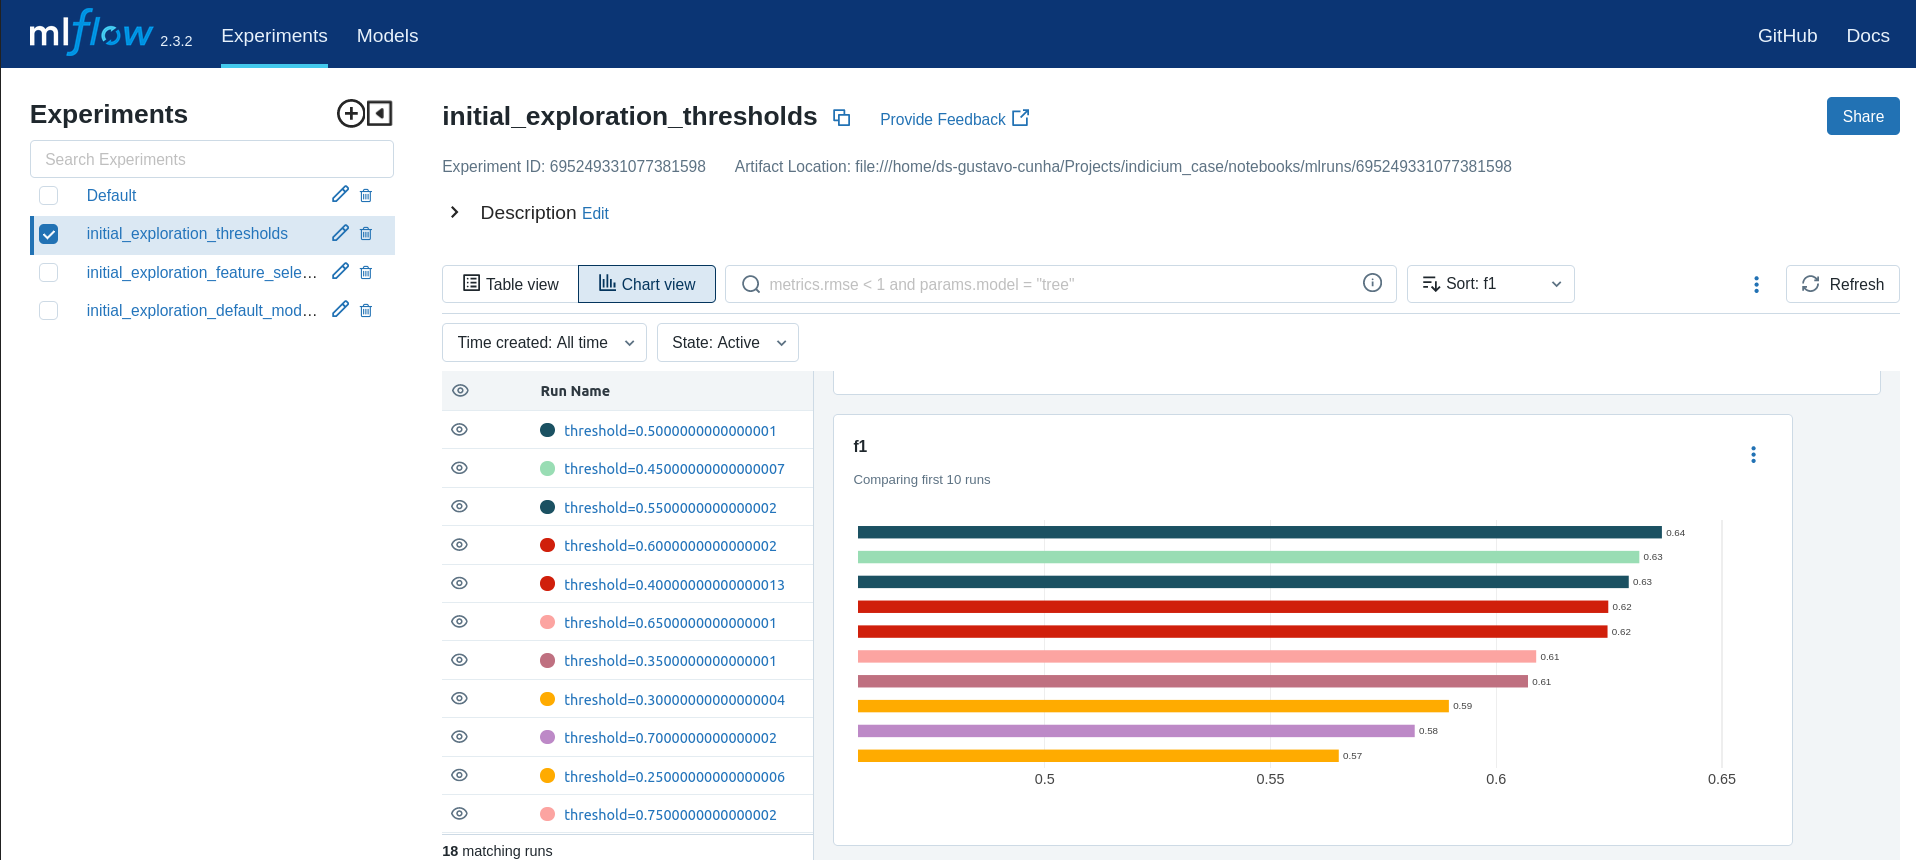

In [87]:
# display MLFlow experiment
Image.open(os.path.join("..", "img", "experiment_tracking", "initial_exploration_thresholds.png"))

## 9.3 - Define best hyperparameters

*Explicitly define best hyper parameters*

In [88]:
# define final threshold
final_threshold = 0.5

In [89]:
# print best model params
display(
    "best_params", best_params, 
    "best_threshold = 0.5"
)

'best_params'

{'preprocessing__rs_transformer__rs__with_scaling': True,
 'preprocessing__rs_transformer__rs__with_centering': False,
 'preprocessing__rs_transformer__rs__unit_variance': False,
 'preprocessing__rs_transformer__rs__quantile_range': (25.0, 75.0),
 'preprocessing__mm_transformer__mm__clip': True,
 'ml_model__reg_lambda': 0.0,
 'ml_model__reg_alpha': 0.0,
 'ml_model__num_leaves': 10,
 'ml_model__n_jobs': -1,
 'ml_model__n_estimators': 100,
 'ml_model__max_depth': 10,
 'ml_model__learning_rate': 0.1,
 'ml_model__class_weight': {0: 3, 1: 7},
 'ml_model__random_state': 7}

'best_threshold = 0.5'

# **10 - PERFORMANCE EVALUATION AND INTERPRETATION**

## 10.1 - Restore Point

*Create a checkpoint of the last dataframe from previous section*

In [90]:
# create a restore point for the previous section dataframe
df_perform = df_tune.copy()

# check dataframe
check_dataframe( df_perform )

*************************************************
Dataframe size in memory: 2.604 MB 

-----------------------------
Dataframe overview:


,Num NAs,Percent NAs,Num unique [include NAs],Data Type
surname,0,0,2.932,object
credit_score,0,0,460,int64
geography,0,0,3,object
gender,0,0,2,object
age,0,0,70,int64
tenure,0,0,11,int64
balance,0,0,6.382,float64
num_of_products,0,0,4,int64
has_cr_card,0,0,2,int64
is_active_member,0,0,2,int64


-----------------------------

 Dataframe shape is (10000, 12) 

-----------------------------


dataframe.sample(5)


,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9045,Sacco,766,Germany,Male,27,5,"126,285.7",1,1,0,"177,614.2",1
8118,Arcuri,577,Spain,Male,28,7,0.0,1,1,0,"143,274.4",0
7733,Akhtar,694,Germany,Female,58,1,"143,212.2",1,0,0,"102,628.6",1
8460,Napolitani,650,Germany,Female,28,5,"122,034.4",3,0,1,"146,663.4",1
1643,Burn,631,France,Female,34,4,"124,379.1",1,1,0,"106,892.9",0


*************************************************


## 10.2 - Training Performance

*Get final model performance on training data*

In [91]:
# define preprocessing pipeline for numerical features
rs_transformer = Pipeline([
    ("rs", RobustScaler(
        with_centering=False, 
        with_scaling=True, 
        quantile_range=(25.0, 75.0), 
        copy=True, 
        unit_variance=False
        )
    )
])
mm_transformer = Pipeline([
    ("mm", MinMaxScaler(
        feature_range=(0, 1), 
        copy=True, 
        clip=True
        )
    )
])

# define preprocessing pipeline for categorical features
cat_transformer = Pipeline([
    ("ohe", OneHotEncoder(
        categories='auto', drop="if_binary", sparse_output=False, dtype=int, handle_unknown='ignore'
        )
    )
])

# define pipeline depending on column type
preprocessing = ColumnTransformer([
    ("rs_transformer", rs_transformer, robust_scaler_cols),
    ("mm_transformer", mm_transformer, min_max_cols),
    ("cat_transformer", cat_transformer, ohe_cols)
    ], remainder="drop", n_jobs=-1, 
)

# instanciate ML model
ml_model = LGBMClassifier(
    reg_lambda=0.0, 
    reg_alpha=0.0,
    num_leaves=10,
    n_jobs=-1,
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    class_weight={0: 3, 1: 7},
    random_state=SEED
)

# add ML model to pipeline
pipe = Pipeline([
    ("preprocessing", preprocessing),
    ("ml_model", ml_model)
])

# Cross-validate Pipeline
cv = cross_validate(
    estimator=pipe, 
    X=X_train, 
    y=y_train, 
    scoring=metrics,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    n_jobs=-1, 
    return_train_score=True, 
    return_estimator=False, 
    error_score=np.nan
)

# get cv metrics
cv_metrics = {metric: np.mean(cv[f'test_{metric}']) for metric in metrics}

# inspect results
cv_metrics

{'PRAuc': 0.7030832000684618,
 'ROC': 0.8673724167250395,
 'F1': 0.6367096918059773,
 'Recall': 0.6535787019997547,
 'Precision': 0.6214003766268574,
 'Accuracy': 0.8481428571428571,
 'NegCrossEntropy': -0.3663222946900946}

## 10.3 - Error analysis

*Perform error analysis on final model to make sure it is ready for production*

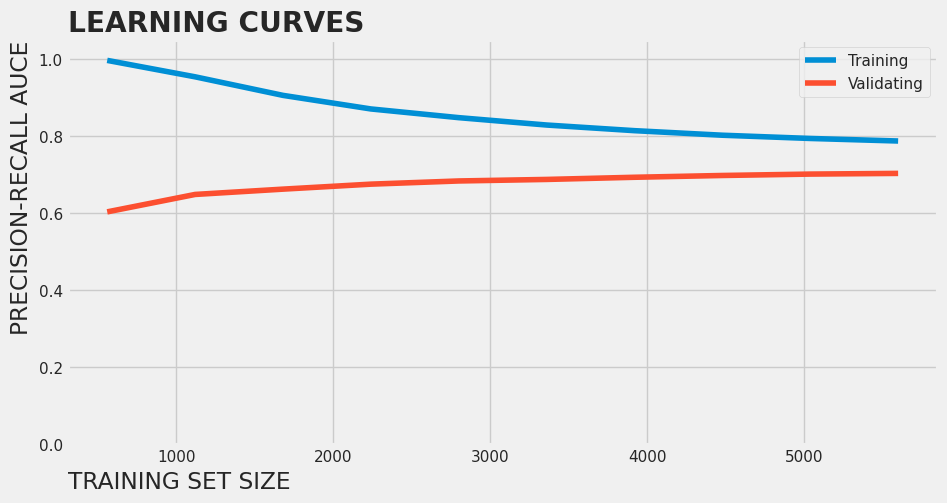

In [92]:
# check learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe, 
    X=X_train, 
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring=precision_recall_auc, 
    n_jobs=-1, shuffle=True, random_state=SEED
    )

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# plot learning curves
sns.lineplot(x = train_sizes, y = train_scores_mean, 
             estimator='mean', errorbar=('ci', 95), n_boot=1000, label = "Training")
sns.lineplot(x = train_sizes, y = test_scores_mean, 
             estimator='mean', errorbar=('ci', 95), n_boot=1000, label = "Validating")
# define plot details
plt.ylabel('PRECISION-RECALL AUCE')
plt.xlabel('TRAINING SET SIZE')
plt.title('LEARNING CURVES')
plt.ylim(0, 1.05)
plt.legend();

## 10.4 - Generalization performance

### 10.4.1 - Final model training

*Get final model performance on validation data*

In [93]:
# fit pipe to data
pipe.fit(
    X=X_train, 
    y=y_train, 
)

# define final threshold
final_threshold = 0.5

# get classification metrics
fold_metrics = get_class_metrics(
    y_true=y_test,
    y_pred=pipe.predict_proba(X_test)[:, 1] > final_threshold,
    y_pred_proba=pipe.predict_proba(X_test)[:, 1]
)

# inspect results
fold_metrics


{'accuracy': 0.8403333333333334,
 'precision': 0.6054313099041534,
 'recall': 0.6202945990180033,
 'f1': 0.6127728375101051,
 'roc_auc': 0.8544330637078426,
 'precision_recall_auc': 0.7027671763468641,
 'log_loss': 0.37037634313656215}

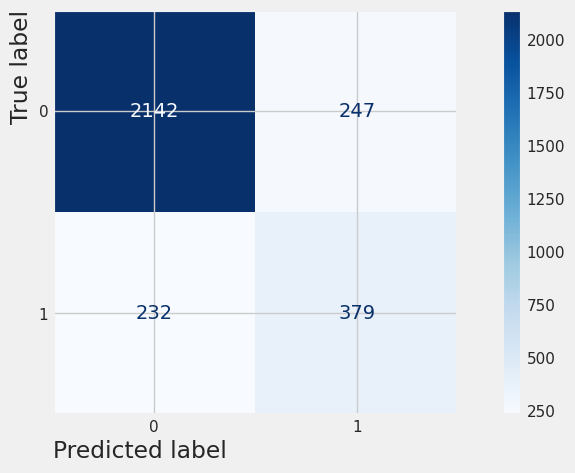

In [94]:
# calculate confusion matrix 
cm = confusion_matrix(
    y_true=y_test, 
    y_pred=pipe.predict_proba(X_test)[:, 1] > final_threshold, 
    labels=pipe.classes_
    )

# prepare confusion matrix display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=pipe.classes_
    )

# plot 
disp.plot(cmap="Blues");

## 10.4 - Define prodution model

*Train ML on "training + validation" data*

In [95]:
# inspect final model
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('rs_transformer',
                                                  Pipeline(steps=[('rs',
                                                                   RobustScaler(with_centering=False))]),
                                                  ['credit_score', 'age']),
                                                 ('mm_transformer',
                                                  Pipeline(steps=[('mm',
                                                                   MinMaxScaler(clip=True))]),
                                                  ['tenure', 'balance',
                                                   'num_of_products',
                                                   'estimated_salary']),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['geography', 'gender',
                                                   'has_cr_card',
                                                   'is_active_member'])])),
                ('ml_model',
                 LGBMClassifier(class_weight={0: 3, 1: 7}, max_depth=10,
                                num_leaves=10, random_state=7))])

## 10.5 - Testing performance

*Get production model performance on testing data*

In [96]:
# load data from source
df_production = pd.read_csv(
    os.path.join(PROJECT_ROOT_PATH, "data", "raw_data", "Abandono_teste.csv"), 
    delimiter=";"
    )

# compile regex to change column names to snake case
pattern = re.compile(r'(?<!^)(?=[A-Z])')
# convert to snake case
df_production.columns = [ pattern.sub('_', col).lower() for col in df_production.columns ];

# inspect loaded data
df_production

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,10001,15798485,Copley,565,France,Male,31,1,0.0,1,0,1,"20,443.1"
1,10002,15588959,T'ang,569,France,Male,34,4,0.0,1,0,1,"4,045.9"
2,10003,15624896,Ku,669,France,Female,20,7,0.0,2,1,0,"128,838.7"
3,10004,15639629,McConnan,694,France,Male,39,4,"173,255.5",1,1,1,"81,293.1"
4,10005,15638852,Ts'ui,504,Spain,Male,28,10,"109,291.4",1,1,1,"187,593.1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10996,15730373,Starks,531,France,Female,34,10,"118,306.8",1,1,0,"26,493.0"
996,10997,15716191,Dixon,575,Germany,Male,49,2,"136,822.7",1,1,0,"2,487.7"
997,10998,15673900,Wilkinson,520,France,Female,74,4,0.0,1,0,0,"26,742.9"
998,10999,15581432,Oatley,675,Spain,Male,23,8,0.0,2,0,0,"162,342.2"


In [101]:
# create a dataframe with row_number and predicitions
df_production_predictions = pd.DataFrame(
    data={
        "rowNumber": df_production["row_number"],
        "predictedValues": pipe.predict(df_production)
          }
)

# save to csv
df_production_predictions.to_csv(
    os.path.join(PROJECT_ROOT_PATH, "data", "processed_data", "test_predictions.csv"),
    index=False
)

# inspect resutls
df_production_predictions

,rowNumber,predictedValues
0,10001,0
1,10002,0
2,10003,0
3,10004,0
4,10005,0
...,...,...
995,10996,0
996,10997,1
997,10998,1
998,10999,0


## 10.6 - Business performance

*Translate testing performance into business results*

In [98]:
# Not possible due to lack of business context and information

# **11 - DEPLOYMENT**

## 11.1 - API creation

*Code to create API for ML predictions*

In [99]:
# no need up this first project iteration

## 11.2 - Docker container

*Code to create a Docker container and deploy ML model*

In [100]:
# no need up this first project iteration